##### top

# This ntb looks at how reliability changes across time and answers the question of how many days are necessary to reliably estimate reliability of a task or a trait to be stable

The motivation is that people are changing every day and many other factors come into play when coming for an experiment and measuring certain aspects and traits over several days. The obvious factors like attention, mood, fatigue, lack of sleep, stress, etc. may significantly affect results of an experiment and when behavioural measures are not collected on the same day as neuronal data, these effects can have significant impact on obtained correlations and measures.

Therefore, here we use longitudinal FMP task that was collected on 6 different days separated by minimum a day and maximum 6 weeks. Every visit had a different form (there are in total 6 forms, A-F) and the order of form was randomised across N=206 participants that successfully finished the task.

Note
--
The data and the task are not yet published and therefore, even though the code assumes them, they are not part of this repository or saved in the data folder.


---
Content
--
* [Load data and code](#Load-data-and-code)
* [Longitudinal FMP](#FMP)
    * [Remove outliers - 2SD on difference for all the combinations](#Remove-outliers---2SD-on-difference-for-all-the-combinations)
        * [Days 3 vs 5 without outliers on all forms](#Days-3-vs-5-without-outliers-on-all-forms)
        * [Concatenated days 3&5 with concatenated days 2&4 without outliers on all forms](#Concatenated-days-3&5-with-concatenated-days-2&4-without-outliers-on-all-forms)
        * [Concatenated days 1&3&5 with concatenated days 2&4&6 without outliers on all forms](#Concatenated-days-1&3&5-with-concatenated-days-2&4&6-without-outliers-on-all-forms)

* [CFMT within-day and far apart in time comparison](#CFMT-within-day-and-far-apart-in-time-comparison)
    * [Remove outliers on CFMT 2SD](#Remove-outliers-on-CFMT-2SD)
        * [Do subsampling of CFMT subjects without outliers](#Do-subsampling-of-CFMT-subjects-without-outliers)
* [Reliability stability across days - all tasks](#Reliability-stability-across-days---all-tasks)


# Load data and code
[top](#top)

In [1]:
import os, sys
import time
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Importing module for functions
functions_modul =  os.path.join("../", "Code", "functions")
sys.path.insert(0, functions_modul)

from reliability_functions import check_df_get_numbers, extract_data, calculate_reliability_between_two_groups
from plot_functions import label_correlation, calculate_reliability_between_two_groups_scatterplots, sharey_ax
from data_processing_functions import process_and_concatenate_all_tasks

# Define path and name
csv_clean_data_path_FMP = "./"
csv_clean_data_path = "../Data/cleaned_CSV" 
path_figures = "./"


## FMP
[top](#top)

Reliability of longitudinal FMP.  For this analysis, only trials with unmorphed face as a target were used.

In [2]:
## longitudinal
# remove participants with too many missed trials
former_bad_guys = set(pd.read_csv(os.path.join(csv_clean_data_path_FMP,'participants_alert.csv'), usecols=["userID"])["userID"].to_numpy())

# load only subjects who have all the days
all_subjects = set(pd.read_csv(os.path.join(csv_clean_data_path_FMP, "experiment_day1_all.csv"), usecols=["userID"]).userID)

for i in range(1,7):
    day="day"+str(i)
    if os.path.exists(os.path.join(csv_clean_data_path_FMP, f"experiment_{day}_all.csv")):
        all_subjects = list(set(all_subjects)&set(pd.read_csv(os.path.join(csv_clean_data_path_FMP, f"experiment_{day}_all.csv"),
                 usecols=["userID"]).userID))
        print(i)

all_subjects = list(set(all_subjects)-former_bad_guys)
print("Num of participants: ", len(all_subjects))

all_days_df = []

for i in range(1,7):
    tmp = None

    day="day"+str(i)
    # check i we have any files
    if os.path.exists(os.path.join(csv_clean_data_path_FMP, f"experiment_{day}_all.csv")):
        tmp = pd.read_csv(os.path.join(csv_clean_data_path_FMP, f"experiment_{day}_all.csv"),
                     usecols=['block', 'stim1', 'stim2',
           'original_target', 'target', 'RT', 'userID', 'observation',
           'stim_gender', 'Form', 'task',
           'num_done', 'stimuli', 'race', 'database', 'age', 'symbolic_age',
           'gender', 'simplified_race', 'order', 'correct_check', 'difficulty',
           'levels', 'correct_flt', 'target_loc_simple', 'target_loc'],
                     dtype={
                            'block': int,
                            'stim1': str,
                            'stim2': str,
                            'original_target': str,
                            'target': str,
                            'RT': float,
                            'userID': str,
                            'observation': str,
                            'stim_gender': str,
                            'Form': str,
                            'task': str,
                            'num_done': int,
                            'stimuli': str,
                            'race': str,
                            'database': str,
                            'age': float,
                            'symbolic_age': str,
                            'gender': str,
                            'simplified_race': str,
                            'order': int,
    #                         'correct_check': object,
                            'difficulty': int,
                            'levels': int,
                            'correct_flt': float,
                            'target_loc_simple': str,
                            'target_loc': str,
                     }
                     )

        tmp = tmp[tmp["userID"].isin(all_subjects)].copy()

        all_days_df.append(tmp)


df_plot_longitudinal = pd.concat(all_days_df)

df_plot_longitudinal.reset_index(inplace=True, drop=True)

# rename col
df_plot_longitudinal.task = df_plot_longitudinal.task.str.replace('perc','perception')
df_plot_longitudinal.rename(columns={"num_done":"visit"}, inplace=True)

# choose only relevant columns
selected_cols = [
    'userID', 'Form', 'task', 'visit',
    'difficulty', 'levels', 'correct_flt', 'target_loc_simple', 'target_loc'
        ]

df_plot_longitudinal = df_plot_longitudinal.loc[:, selected_cols].copy()

1
2
3
4
5
6
Num of participants:  206


## Remove outliers - 2SD on difference for all the combinations
[top](#top)

The cleaning should be done on all pairs: difference in score on days 3 and 5, then 35 and 24, and also 135 and 246, take a union of all the outliers and remove them.


In [3]:
outliers_longitudinal = []
std_thr = 2

for d1, d2 in [([3], [5]), ([3,5], [2,4]), ([1,3,5], [2,4,6])]:
    
    # compute differences
    score_diff_FMP = (df_plot_longitudinal[df_plot_longitudinal["visit"].isin(d1)].groupby(['userID']).mean() - df_plot_longitudinal[df_plot_longitudinal["visit"].isin(d2)].groupby(['userID']).mean()).reset_index()

    mean = score_diff_FMP['correct_flt'].mean()
    std = score_diff_FMP['correct_flt'].std()

    # get subjects who are outliers
    outliers_tmp = score_diff_FMP.loc[(score_diff_FMP["correct_flt"] > mean+std_thr*std)|(score_diff_FMP["correct_flt"] < mean-std_thr*std), "userID"].values
#     outliers_longitudinal.append(outliers_tmp)
    outliers_longitudinal += list(outliers_tmp)

    # num of subjects
    print(len(outliers_tmp))
    
# print(f'total: {len(set([item for sublist in outliers_longitudinal for item in sublist]))}')
# print(len(outliers_longitudinal))
print(f'unique total: {len(set(outliers_longitudinal))}')


10
9
6
unique total: 23


### Days 3 vs 5 without outliers on all forms
[top](#top)

In [4]:
# get subjects who are not outliers
not_outliers_FMP_long_all_days = set(df_plot_longitudinal.userID)-set(outliers_longitudinal)
# num of subjects
N_FMP_long_nooutliers_all_days = len(not_outliers_FMP_long_all_days)
assert N_FMP_long_nooutliers_all_days == 206-23
print(f'Out of {df_plot_longitudinal["userID"].unique().size} we take {N_FMP_long_nooutliers_all_days}, we drop {len(set(outliers_longitudinal))}')


## Day 3
# select only relevant part of the df
df_day3 = df_plot_longitudinal.loc[(df_plot_longitudinal['visit']==3)&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
df_day3 = df_day3.groupby('userID').sample(df_day3['userID'].value_counts().min(), random_state=0)

## Day 5
# select only relevant part of the df
df_day5 = df_plot_longitudinal.loc[(df_plot_longitudinal['visit']==5)&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
df_day5 = df_day5.groupby('userID').sample(df_day5['userID'].value_counts().min(), random_state=0)


# select only the non-outliers
df_day3_nooutliers = df_day3.loc[df_day3["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)
df_day5_nooutliers = df_day5.loc[df_day5["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)


## extract data
# max number of trials
total_n_trials_day3_nooutliers = check_df_get_numbers(df_day3_nooutliers, N_FMP_long_nooutliers_all_days)
# extract the data
all_trials_reshaped_target0_day3_nooutliers = extract_data(df_day3_nooutliers, total_n_trials_day3_nooutliers, measure="correct_flt")


# max number of trials
total_n_trials_day5_nooutliers = check_df_get_numbers(df_day5_nooutliers, N_FMP_long_nooutliers_all_days)
# extract the data
all_trials_reshaped_target0_day5_nooutliers = extract_data(df_day5_nooutliers, total_n_trials_day5_nooutliers, measure="correct_flt")



## Days 3 and 5
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['visit'].isin([3,5]))&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_day3and5_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_day3and5_concat_nooutliers = extract_data(df_short, total_n_trials_day3and5_concat_nooutliers, measure="correct_flt")




Out of 206 we take 183, we drop 23
Total number of trials is 129.
Total number of trials is 129.
259
Total number of trials is 259.


In [5]:
# how many samples we want to correlate
n_repeats = 10**3

# do day 3 vs 5
array_corr_fxn_day3vs5_nooutliers, n_trials_list_day3vs5_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_target0_day3_nooutliers, all_trials_reshaped_target0_day5_nooutliers, total_n_trials_day3_nooutliers+total_n_trials_day5_nooutliers, step=6)

# and concat
array_corr_fxn_day3and5_concat_nooutliers, n_trials_list_day3and5_concat_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_target0_day3and5_concat_nooutliers, all_trials_reshaped_target0_day3and5_concat_nooutliers, total_n_trials_day3and5_concat_nooutliers, step=6)


Process took: 12.95 s which is 0.22 min.
Process took: 14.47 s which is 0.24 min.


### Concatenated days 3&5 with concatenated days 2&4 without outliers on all forms
[top](#top)

In [6]:
## Days 2 and 4
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['visit'].isin([2,4]))&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_day2and4_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_day2and4_concat_nooutliers = extract_data(df_short, total_n_trials_day2and4_concat_nooutliers, measure="correct_flt")


## Days 2, 3, 4 and 5
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['visit'].isin([2,3,4,5]))&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_day2345_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_day2345_concat_nooutliers = extract_data(df_short, total_n_trials_day2345_concat_nooutliers, measure="correct_flt")




259
Total number of trials is 259.
521
Total number of trials is 521.


In [7]:
# do 3&5 vs 2&4

array_corr_fxn_day35vs24_nooutliers, n_trials_list_day35vs24_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_target0_day3and5_concat_nooutliers, all_trials_reshaped_target0_day2and4_concat_nooutliers, 2*total_n_trials_day2and4_concat_nooutliers, step=8)

# and three+five concat
array_corr_fxn_day2345_concat_nooutliers, n_trials_list_day2345_concat_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_target0_day2345_concat_nooutliers, all_trials_reshaped_target0_day2345_concat_nooutliers, total_n_trials_day2345_concat_nooutliers, step=16)


Process took: 24.87 s which is 0.41 min.
Process took: 15.04 s which is 0.25 min.


### Concatenated days 1&3&5 with concatenated days 2&4&6 without outliers on all forms
[top](#top)

In [8]:
## Days 1 and 3 and 5
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['visit'].isin([1,3,5]))&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_day135_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_day135_concat_nooutliers = extract_data(df_short, total_n_trials_day135_concat_nooutliers, measure="correct_flt")


## Days 2 and 4 and 6
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['visit'].isin([2,4,6]))&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_day246_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_day246_concat_nooutliers = extract_data(df_short, total_n_trials_day246_concat_nooutliers, measure="correct_flt")


## All days
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_alldays_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_alldays_concat_nooutliers = extract_data(df_short, total_n_trials_alldays_concat_nooutliers, measure="correct_flt")


389
Total number of trials is 389.
389
Total number of trials is 389.
786
Total number of trials is 786.


In [9]:
# how many samples we want to correlate
n_repeats = 10**3


# do 135 vs 246
array_corr_fxn_day135vs246_nooutliers, n_trials_list_day135vs246_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_target0_day135_concat_nooutliers, all_trials_reshaped_target0_day246_concat_nooutliers, total_n_trials_day135_concat_nooutliers+total_n_trials_day246_concat_nooutliers, step=16)

# and all days concat_nooutliers
array_corr_fxn_alldays_concat_nooutliers, n_trials_list_alldays_concat_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_target0_alldays_concat_nooutliers, all_trials_reshaped_target0_alldays_concat_nooutliers, total_n_trials_alldays_concat_nooutliers, step=15)


Process took: 23.56 s which is 0.39 min.
Process took: 31.36 s which is 0.52 min.


### Plot
[top](#top)

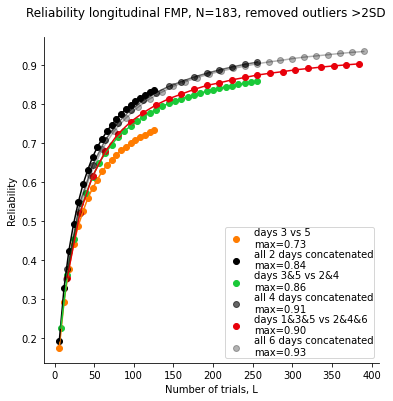

In [10]:
palette = sns.color_palette("bright", n_colors=4, as_cmap=False)
colour_day3and5 = palette[1]
colour_day35and24 = palette[2]
colour_day135and246 = palette[3]

fig, ax = plt.subplots(1,1, figsize=(6,6), sharey=True)

ax.scatter(n_trials_list_day3vs5_nooutliers, np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1), label=f'days 3 vs 5\nmax={np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1).max():.2f}', color=colour_day3and5)
ax.plot(n_trials_list_day3vs5_nooutliers, np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1), color=colour_day3and5)
# ax.legend()

# add the full concatenated 2 forms
ax.scatter(n_trials_list_day3and5_concat_nooutliers, np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1), label=f'all 2 days concatenated\nmax={np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1).max():.2f}', color='k')
ax.plot(n_trials_list_day3and5_concat_nooutliers, np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1), color='k')


####################
ax.scatter(n_trials_list_day35vs24_nooutliers, np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1), label=f'days 3&5 vs 2&4\nmax={np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1).max():.2f}', color=colour_day35and24)
ax.plot(n_trials_list_day35vs24_nooutliers, np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1), color=colour_day35and24)
# ax.legend()

# add the full concatenated 4 forms
ax.scatter(n_trials_list_day2345_concat_nooutliers, np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1), label=f'all 4 days concatenated\nmax={np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1).max():.2f}', color='k', alpha=0.6)
ax.plot(n_trials_list_day2345_concat_nooutliers, np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1), color='k', alpha=0.6)


####################
ax.scatter(n_trials_list_day135vs246_nooutliers, np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1), label=f'days 1&3&5 vs 2&4&6\nmax={np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1).max():.2f}', color=colour_day135and246)
ax.plot(n_trials_list_day135vs246_nooutliers, np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1), color=colour_day135and246)
# ax.legend()

# add the full concatenated 6 forms
ax.scatter(n_trials_list_alldays_concat_nooutliers, np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1), label=f'all 6 days concatenated\nmax={np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1).max():.2f}', color='k', alpha=0.3)
ax.plot(n_trials_list_alldays_concat_nooutliers, np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1), color='k', alpha=0.3)

ax.legend(loc="lower right", columnspacing=0.01, labelspacing=0.01, borderpad=0.05)

ax.set_ylabel('Reliability')
ax.set_xlabel('Number of trials, L')

# ax.set_title(f'Day 3 and 5\nN={len(all_subjects)}, n$_{{\mathrm{{concat}}}}$={total_n_trials_day3and5_concat_nooutliers}, n$_{{\mathrm{{day3}}}}$={total_n_trials_day3}, n$_{{\mathrm{{day5}}}}$={total_n_trials_day5}')
# ax.set_title(f'Day 3&5 and 2&4\nN={len(all_subjects)}, n$_{{\mathrm{{concat}}}}$={total_n_trials_day2345_concat_nooutliers}, n$_{{\mathrm{{day35}}}}$={total_n_trials_day3and5_concat_nooutliers}, n$_{{\mathrm{{day5}}}}$={total_n_trials_day2and4_concat_nooutliers}')
# ax.set_title(f'All days\nN={len(all_subjects)}, n$_{{\mathrm{{concat}}}}$={total_n_trials_alldays_concat_nooutliers}, n$_{{\mathrm{{day3}}}}$={total_n_trials_day135_concat_nooutliers}, n$_{{\mathrm{{day5}}}}$={total_n_trials_day246_concat_nooutliers}')


sns.despine()

# plt.suptitle(f'Reliability FMP, unmorphed target only, Day 3 and 5\nN={len(all_subjects)}, n$_{{\mathrm{{concat}}}}$={total_n_trials_day3and5_concat_nooutliers}, n$_{{\mathrm{{day3}}}}$={total_n_trials_day3}, n$_{{\mathrm{{day5}}}}$={total_n_trials_day5}')
plt.suptitle(f'Reliability longitudinal FMP, N={N_FMP_long_nooutliers_all_days}, removed outliers >2SD', y=.95)
plt.show()

## CFMT within-day and far apart in time comparison
[top](#top)

### Remove outliers on CFMT 2SD
[top](#top)

The idea is that if people have very different score on the first and the second visit, they then drive the correlations to low values. Therefore, we want to remove this bias and look again at the same measures, i.e. Aus vs F version of CFMT, first visits of participants and then compare between having done the CFMT on separate days and on the same day.

#### Compare Aus and F first visit only, same days
[top](#top)

That means, only the second dataset and only first time visitors

In [11]:
# load participants per each of the 4 forms
f2 = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_F2-cleaned_data.csv"), usecols=['userID']).userID)
f = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_F-cleaned_data.csv"), usecols=['userID']).userID)
aus2 = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_Aus2-cleaned_data.csv"), usecols=['userID']).userID)
aus = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_Aus-cleaned_data.csv"), usecols=['userID']).userID)

# select participants from the second who do not have the first to include them
take_aus2 = set(aus2) - set(aus)  # take from aus 2 everyone who does not have aus 1
take_f2 = set(f2) - set(f)  # take from female 2 everyone who does not have female 1
# overlap
first_time_subjects = list(take_aus2&take_f2)#&set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT-cleaned_data.csv"), usecols=['userID']).userID))

print(f"""Number of participants:
First F: {len(f)}
First Aus: {len(aus)}
Second F: {len(f2)}
Second Aus: {len(aus2)}

Number of participants from the second that do not have the first:
Aus: {len(take_aus2)}
F: {len(take_f2)}

Overlap: {len(first_time_subjects)}
""")


# df_CFMT_orig = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT-cleaned_data.csv'))
df_CFMT_Aus2 = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT_Aus2-cleaned_data.csv'))
df_CFMT_F2 = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT_F2-cleaned_data.csv'))


# take only the full data
# df_CFMT_orig = df_CFMT_orig[df_CFMT_orig["userID"].isin(first_time_subjects)].reset_index(drop=True)
df_CFMT_Aus2 = df_CFMT_Aus2[df_CFMT_Aus2["userID"].isin(first_time_subjects)].reset_index(drop=True)
df_CFMT_F2 = df_CFMT_F2[df_CFMT_F2["userID"].isin(first_time_subjects)].reset_index(drop=True)


### remove outliers
score_diff_CFMT_Aus2F2, mean, std = None, None, None
std_thr = 2

score_diff_CFMT_Aus2F2 = (df_CFMT_Aus2.groupby(['userID']).mean() - df_CFMT_F2.groupby(['userID']).mean()).reset_index()
mean = score_diff_CFMT_Aus2F2['correct'].mean()
std = score_diff_CFMT_Aus2F2['correct'].std()

not_outliers_CFMT_Aus2F2 = score_diff_CFMT_Aus2F2.loc[(score_diff_CFMT_Aus2F2["correct"] <= mean+std_thr*std)&(score_diff_CFMT_Aus2F2["correct"] >= mean-std_thr*std), "userID"].values


# take only shared subjects and what we need
df_CFMT_Aus2_nooutliers = df_CFMT_Aus2.loc[df_CFMT_Aus2["userID"].isin(not_outliers_CFMT_Aus2F2), ['userID', 'correct']].reset_index(drop=True)
df_CFMT_F2_nooutliers = df_CFMT_F2.loc[df_CFMT_F2["userID"].isin(not_outliers_CFMT_Aus2F2), ['userID', 'correct']].reset_index(drop=True)


### Extract data
N_CFMT_Aus2F2_nooutliers = len(not_outliers_CFMT_Aus2F2)
print(f'After cleaning taking {N_CFMT_Aus2F2_nooutliers} subjects.\n')

# max number of trials
total_n_trials_CFMT_Aus2_nooutliers = check_df_get_numbers(df_CFMT_Aus2_nooutliers, N_CFMT_Aus2F2_nooutliers)
total_n_trials_CFMT_F2_nooutliers = check_df_get_numbers(df_CFMT_F2_nooutliers, N_CFMT_Aus2F2_nooutliers)

# extract the data
all_trials_reshaped_CFMT_Aus2_nooutliers = extract_data(df_CFMT_Aus2_nooutliers, total_n_trials_CFMT_Aus2_nooutliers, measure="correct")
all_trials_reshaped_CFMT_F2_nooutliers = extract_data(df_CFMT_F2_nooutliers, total_n_trials_CFMT_F2_nooutliers, measure="correct")


## add concat data
df_CFMT_Aus2F2_concat_nooutliers = pd.concat([df_CFMT_Aus2_nooutliers, df_CFMT_F2_nooutliers]).reset_index(drop=True)

# max number of trials
total_n_trials_CFMT_Aus2F2_concat_nooutliers = check_df_get_numbers(df_CFMT_Aus2F2_concat_nooutliers, N_CFMT_Aus2F2_nooutliers)
all_trials_reshaped_CFMT_Aus2F2_concat_nooutliers = extract_data(df_CFMT_Aus2F2_concat_nooutliers, total_n_trials_CFMT_Aus2F2_concat_nooutliers, measure="correct")


Number of participants:
First F: 85
First Aus: 94
Second F: 110
Second Aus: 117

Number of participants from the second that do not have the first:
Aus: 50
F: 49

Overlap: 44

After cleaning taking 42 subjects.

Total number of trials is 72.
Total number of trials is 72.
Total number of trials is 144.


In [12]:
# # how many samples we want to correlate
# n_repeats = 10**3

array_corr_fxn_CFMT_Aus2F2_nooutliers, n_trials_list_CFMT_Aus2F2_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus2_nooutliers, all_trials_reshaped_CFMT_F2_nooutliers, total_n_trials_CFMT_Aus2_nooutliers+total_n_trials_CFMT_F2_nooutliers, step=8)

# and all days concat
array_corr_fxn_CFMT_Aus2F2_concat_nooutliers, n_trials_list_CFMT_Aus2F2_concat_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus2F2_concat_nooutliers, all_trials_reshaped_CFMT_Aus2F2_concat_nooutliers, total_n_trials_CFMT_Aus2F2_concat_nooutliers, step=8)


Process took: 4.34 s which is 0.07 min.
Process took: 4.79 s which is 0.08 min.


#### Compare Aus and F first visit only, separate days
[top](#top)

In [13]:
# load participants per each of the 4 forms
f = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_F-cleaned_data.csv"), usecols=['userID']).userID)
aus = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_Aus-cleaned_data.csv"), usecols=['userID']).userID)

# overlap
first_time_subjects = list(aus&f)#&set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT-cleaned_data.csv"), usecols=['userID']).userID))

print(f"""Number of participants:
First F: {len(f)}
First Aus: {len(aus)}

Overlap: {len(first_time_subjects)}
""")

# load data
# df_CFMT_orig = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT-cleaned_data.csv'))
df_CFMT_Aus = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT_Aus-cleaned_data.csv'))
df_CFMT_F = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT_F-cleaned_data.csv'))


# take only the full data
# df_CFMT_orig = df_CFMT_orig[df_CFMT_orig["userID"].isin(first_time_subjects)].reset_index(drop=True)
df_CFMT_Aus = df_CFMT_Aus[df_CFMT_Aus["userID"].isin(first_time_subjects)].reset_index(drop=True)
df_CFMT_F = df_CFMT_F[df_CFMT_F["userID"].isin(first_time_subjects)].reset_index(drop=True)


### remove outliers
score_diff_CFMT_AusF, mean, std = None, None, None
std_thr = 2

score_diff_CFMT_AusF = (df_CFMT_Aus.groupby(['userID']).mean() - df_CFMT_F.groupby(['userID']).mean()).reset_index()
mean = score_diff_CFMT_AusF['correct'].mean()
std = score_diff_CFMT_AusF['correct'].std()

not_outliers_CFMT_AusF = score_diff_CFMT_AusF.loc[(score_diff_CFMT_AusF["correct"] <= mean+std_thr*std)&(score_diff_CFMT_AusF["correct"] >= mean-std_thr*std), "userID"].values


# take only shared subjects and what we need
df_CFMT_Aus_nooutliers = df_CFMT_Aus.loc[df_CFMT_Aus["userID"].isin(not_outliers_CFMT_AusF), ['userID', 'correct']].reset_index(drop=True)
df_CFMT_F_nooutliers = df_CFMT_F.loc[df_CFMT_F["userID"].isin(not_outliers_CFMT_AusF), ['userID', 'correct']].reset_index(drop=True)


### Extract data
N_CFMT_AusF_nooutliers = len(not_outliers_CFMT_AusF)
print(f'After cleaning taking {N_CFMT_AusF_nooutliers} subjects.\n')

# max number of trials
total_n_trials_CFMT_Aus_nooutliers = check_df_get_numbers(df_CFMT_Aus_nooutliers, N_CFMT_AusF_nooutliers)
total_n_trials_CFMT_F_nooutliers = check_df_get_numbers(df_CFMT_F_nooutliers, N_CFMT_AusF_nooutliers)

# extract the data
all_trials_reshaped_CFMT_Aus_nooutliers = extract_data(df_CFMT_Aus_nooutliers, total_n_trials_CFMT_Aus_nooutliers, measure="correct")
all_trials_reshaped_CFMT_F_nooutliers = extract_data(df_CFMT_F_nooutliers, total_n_trials_CFMT_F_nooutliers, measure="correct")


## add concat data
df_CFMT_AusF_concat_nooutliers = pd.concat([df_CFMT_Aus_nooutliers, df_CFMT_F_nooutliers]).reset_index(drop=True)

# max number of trials
total_n_trials_CFMT_AusF_concat_nooutliers = check_df_get_numbers(df_CFMT_AusF_concat_nooutliers, N_CFMT_AusF_nooutliers)
all_trials_reshaped_CFMT_AusF_concat_nooutliers = extract_data(df_CFMT_AusF_concat_nooutliers, total_n_trials_CFMT_AusF_concat_nooutliers, measure="correct")


Number of participants:
First F: 85
First Aus: 94

Overlap: 81

After cleaning taking 77 subjects.

Total number of trials is 72.
Total number of trials is 72.
Total number of trials is 144.


In [14]:
# # how many samples we want to correlate
# n_repeats = 10**3

array_corr_fxn_CFMT_AusF_nooutliers, n_trials_list_CFMT_AusF_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus_nooutliers, all_trials_reshaped_CFMT_F_nooutliers, total_n_trials_CFMT_Aus_nooutliers+total_n_trials_CFMT_F_nooutliers, step=8)

# and all days concat
array_corr_fxn_CFMT_AusF_concat_nooutliers, n_trials_list_CFMT_AusF_concat_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_AusF_concat_nooutliers, all_trials_reshaped_CFMT_AusF_concat_nooutliers, total_n_trials_CFMT_AusF_concat_nooutliers, step=8)


Process took: 4.48 s which is 0.07 min.
Process took: 4.88 s which is 0.08 min.


#### Compare original and F first visit only, 200-250 days apart
[top](#top)

In [15]:
# load participants per each of the 4 forms
f = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT_F-cleaned_data.csv"), usecols=['userID']).userID)
orig = set(pd.read_csv(os.path.join(csv_clean_data_path, "CFMT-cleaned_data.csv"), usecols=['userID']).userID)

# overlap
first_time_subjects = list(f&orig)

print(f"""Number of participants:
First F: {len(f)}
First Original: {len(orig)}

Overlap: {len(first_time_subjects)}
""")

# load data
df_CFMT_orig = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT-cleaned_data.csv'))
df_CFMT_Fmonth = pd.read_csv(os.path.join(csv_clean_data_path, 'CFMT_F-cleaned_data.csv'))


# take only the full data
df_CFMT_orig = df_CFMT_orig[df_CFMT_orig["userID"].isin(first_time_subjects)].reset_index(drop=True)
df_CFMT_Fmonth = df_CFMT_Fmonth[df_CFMT_Fmonth["userID"].isin(first_time_subjects)].reset_index(drop=True)


### remove outliers
score_diff_CFMT_origFmonth, mean, std = None, None, None
std_thr = 2

score_diff_CFMT_origFmonth = (df_CFMT_orig.groupby(['userID']).mean() - df_CFMT_Fmonth.groupby(['userID']).mean()).reset_index()
mean = score_diff_CFMT_origFmonth['correct'].mean()
std = score_diff_CFMT_origFmonth['correct'].std()

not_outliers_CFMT_origFmonth = score_diff_CFMT_origFmonth.loc[(score_diff_CFMT_origFmonth["correct"] <= mean+std_thr*std)&(score_diff_CFMT_origFmonth["correct"] >= mean-std_thr*std), "userID"].values


# take only shared subjects and what we need
df_CFMT_orig_nooutliers = df_CFMT_orig.loc[df_CFMT_orig["userID"].isin(not_outliers_CFMT_origFmonth), ['userID', 'correct']].reset_index(drop=True)
df_CFMT_Fmonth_nooutliers = df_CFMT_Fmonth.loc[df_CFMT_Fmonth["userID"].isin(not_outliers_CFMT_origFmonth), ['userID', 'correct']].reset_index(drop=True)


### Extract data
N_CFMT_origFmonth_nooutliers = len(not_outliers_CFMT_origFmonth)
print(f'After cleaning taking {N_CFMT_origFmonth_nooutliers} subjects.\n')

# max number of trials
total_n_trials_CFMT_orig_nooutliers = check_df_get_numbers(df_CFMT_orig_nooutliers, N_CFMT_origFmonth_nooutliers)
total_n_trials_CFMT_Fmonth_nooutliers = check_df_get_numbers(df_CFMT_Fmonth_nooutliers, N_CFMT_origFmonth_nooutliers)

# extract the data
all_trials_reshaped_CFMT_orig_nooutliers = extract_data(df_CFMT_orig_nooutliers, total_n_trials_CFMT_orig_nooutliers, measure="correct")
all_trials_reshaped_CFMT_Fmonth_nooutliers = extract_data(df_CFMT_Fmonth_nooutliers, total_n_trials_CFMT_Fmonth_nooutliers, measure="correct")


## add concat data
df_CFMT_origFmonth_concat_nooutliers = pd.concat([df_CFMT_orig_nooutliers, df_CFMT_Fmonth_nooutliers]).reset_index(drop=True)

# max number of trials
total_n_trials_CFMT_origFmonth_concat_nooutliers = check_df_get_numbers(df_CFMT_origFmonth_concat_nooutliers, N_CFMT_origFmonth_nooutliers)
all_trials_reshaped_CFMT_origFmonth_concat_nooutliers = extract_data(df_CFMT_origFmonth_concat_nooutliers, total_n_trials_CFMT_origFmonth_concat_nooutliers, measure="correct")


Number of participants:
First F: 85
First Original: 234

Overlap: 82

After cleaning taking 79 subjects.

Total number of trials is 72.
Total number of trials is 72.
Total number of trials is 144.


In [16]:
# # how many samples we want to correlate
# n_repeats = 10**3

array_corr_fxn_CFMT_origFmonth_nooutliers, n_trials_list_CFMT_origFmonth_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_orig_nooutliers, all_trials_reshaped_CFMT_Fmonth_nooutliers, total_n_trials_CFMT_orig_nooutliers+total_n_trials_CFMT_Fmonth_nooutliers, step=8)

# and all days concat
array_corr_fxn_CFMT_origFmonth_concat_nooutliers, n_trials_list_CFMT_origFmonth_concat_nooutliers = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_origFmonth_concat_nooutliers, all_trials_reshaped_CFMT_origFmonth_concat_nooutliers, total_n_trials_CFMT_origFmonth_concat_nooutliers, step=8)


Process took: 4.53 s which is 0.08 min.
Process took: 4.94 s which is 0.08 min.


#### Plot

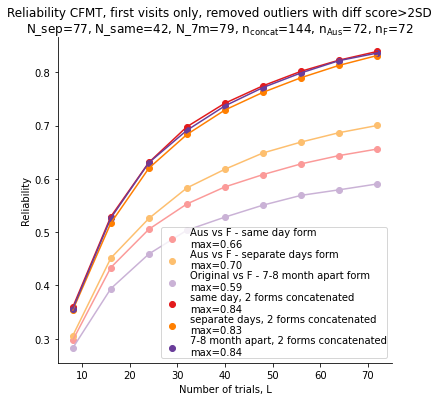

In [17]:
pallette_CFMT = sns.color_palette("Paired", n_colors=20, as_cmap=False)[4:]
labels = []

fig, ax = plt.subplots(1,1, figsize=(6,6))

for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_Aus2F2_nooutliers, n_trials_list_CFMT_Aus2F2_nooutliers, 'Aus vs F - same day'),
    (array_corr_fxn_CFMT_AusF_nooutliers, n_trials_list_CFMT_AusF_nooutliers, 'Aus vs F - separate days'),
    (array_corr_fxn_CFMT_origFmonth_nooutliers, n_trials_list_CFMT_origFmonth_nooutliers, 'Original vs F - 7-8 month apart'),
]):
    # plot Aus vs F
    ax.scatter(x_list, np.nanmean(arr, axis=1), label=f'{label} form\nmax={np.nanmean(arr, axis=1).max():.2f}', color=pallette_CFMT[2*i])
    ax.plot(x_list, np.nanmean(arr, axis=1), color=pallette_CFMT[2*i])
    
    labels += label.split(' - ')[1:]

# add the full concatenated 2 forms
for i, (arr, x_list) in enumerate([
    (array_corr_fxn_CFMT_Aus2F2_concat_nooutliers, n_trials_list_CFMT_Aus2F2_concat_nooutliers),
    (array_corr_fxn_CFMT_AusF_concat_nooutliers, n_trials_list_CFMT_AusF_concat_nooutliers),
    (array_corr_fxn_CFMT_origFmonth_concat_nooutliers, n_trials_list_CFMT_origFmonth_concat_nooutliers),
]):
    
    ax.scatter(x_list, np.nanmean(arr, axis=1), label=f'{labels[i]}, 2 forms concatenated\nmax={np.nanmean(arr, axis=1).max():.2f}', color=pallette_CFMT[2*i+1])
    ax.plot(x_list, np.nanmean(arr, axis=1), color=pallette_CFMT[2*i+1])

ax.legend(loc="lower right", columnspacing=0.01, labelspacing=0.01, borderpad=0.05)

ax.set_ylabel('Reliability')
ax.set_xlabel('Number of trials, L')

sns.despine()

plt.suptitle(f'Reliability CFMT, first visits only, removed outliers with diff score>{std_thr}SD\nN_sep={N_CFMT_AusF_nooutliers}, N_same={N_CFMT_Aus2F2_nooutliers}, N_7m={N_CFMT_origFmonth_nooutliers}, n$_{{\mathrm{{concat}}}}$={total_n_trials_CFMT_Aus2F2_concat_nooutliers}, n$_{{\mathrm{{Aus}}}}$={total_n_trials_CFMT_Aus2_nooutliers}, n$_{{\mathrm{{F}}}}$={total_n_trials_CFMT_F2_nooutliers}', 
             y=.95)
plt.show()

#### Do subsampling of CFMT subjects without outliers
[top](#top)

To compensate for the fact that there is only 42 subjects who have it on the same day and 77 or 79 that have it on separate days. To be able to directly compare, downsample the same day CFMT to have the same number of subjects as the separate days.

In [18]:
# how many times to sample the number of subjects
N_iter_sampling = 50

# predefine arrays
array_corr_fxn_CFMT_AusF_nooutliers_sampled = np.zeros((N_iter_sampling,)+ array_corr_fxn_CFMT_AusF_nooutliers.shape)
array_corr_fxn_CFMT_concat_AusF_nooutliers_sampled = np.zeros((N_iter_sampling,)+ array_corr_fxn_CFMT_AusF_concat_nooutliers.shape)
# n_trials_list_CFMT_AusF_sampled = np.zeros((N_iter_sampling,)+ n_trials_list_CFMT_Aus.shape)
# n_trials_list_CFMT_concat_AusF_sampled = np.zeros((N_iter_sampling,)+ n_trials_list_CFMT_concat_AusF.shape)

print(f"""Without ourliers in difference score (>{std_thr} SD)
N same day: {N_CFMT_Aus2F2_nooutliers}\nN separate days: {N_CFMT_AusF_nooutliers}
""")

# check that dimensions are ok
assert all_trials_reshaped_CFMT_Aus_nooutliers.shape[0]==N_CFMT_AusF_nooutliers

for i in range(N_iter_sampling):
    # define seed
    rng_N_sample = np.random.default_rng(i)

    # randomly sample people
    rnd_idx = rng_N_sample.choice(range(N_CFMT_AusF_nooutliers), N_CFMT_Aus2F2_nooutliers, replace=False)
    
    # do the calculation 
    array_corr_fxn_CFMT_AusF_nooutliers_sampled[i], n_trials_list_CFMT_AusF_nooutliers_sampled = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_Aus_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_F_nooutliers[rnd_idx,:], total_n_trials_CFMT_Aus_nooutliers+total_n_trials_CFMT_F_nooutliers, step=8)

    # and all days concat
    array_corr_fxn_CFMT_concat_AusF_nooutliers_sampled[i], n_trials_list_CFMT_concat_AusF_nooutliers_sampled = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_AusF_concat_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_AusF_concat_nooutliers[rnd_idx,:], total_n_trials_CFMT_AusF_concat_nooutliers, step=8)



Without ourliers in difference score (>2 SD)
N same day: 42
N separate days: 77

Process took: 4.35 s which is 0.07 min.
Process took: 4.73 s which is 0.08 min.
Process took: 4.34 s which is 0.07 min.
Process took: 4.77 s which is 0.08 min.
Process took: 4.33 s which is 0.07 min.
Process took: 4.76 s which is 0.08 min.
Process took: 4.32 s which is 0.07 min.
Process took: 4.79 s which is 0.08 min.
Process took: 4.39 s which is 0.07 min.
Process took: 4.76 s which is 0.08 min.
Process took: 4.35 s which is 0.07 min.
Process took: 4.77 s which is 0.08 min.
Process took: 4.36 s which is 0.07 min.
Process took: 4.72 s which is 0.08 min.
Process took: 4.39 s which is 0.07 min.
Process took: 4.77 s which is 0.08 min.
Process took: 4.35 s which is 0.07 min.
Process took: 4.75 s which is 0.08 min.
Process took: 4.36 s which is 0.07 min.
Process took: 4.74 s which is 0.08 min.
Process took: 3.59 s which is 0.06 min.
Process took: 3.05 s which is 0.05 min.
Process took: 2.70 s which is 0.04 min.

In [19]:
# how many times to sample the number of subjects
N_iter_sampling = 50

# predefine arrays
array_corr_fxn_CFMT_origFmonth_nooutliers_sampled = np.zeros((N_iter_sampling,)+ array_corr_fxn_CFMT_origFmonth_nooutliers.shape)
array_corr_fxn_CFMT_concat_origFmonth_nooutliers_sampled = np.zeros((N_iter_sampling,)+ array_corr_fxn_CFMT_origFmonth_concat_nooutliers.shape)
# n_trials_list_CFMT_origFmonth_sampled = np.zeros((N_iter_sampling,)+ n_trials_list_CFMT_orig.shape)
# n_trials_list_CFMT_concat_origFmonth_sampled = np.zeros((N_iter_sampling,)+ n_trials_list_CFMT_concat_origFmonth.shape)

print(f"""Without ourliers in difference score (>{std_thr} SD)
N same day: {N_CFMT_Aus2F2_nooutliers}\nN separate days: {N_CFMT_origFmonth_nooutliers}
""")

# check that dimensions are ok
assert all_trials_reshaped_CFMT_orig_nooutliers.shape[0]==N_CFMT_origFmonth_nooutliers

for i in range(N_iter_sampling):
    # define seed
    rng_N_sample = np.random.default_rng(i)

    # randomly sample people
    rnd_idx = rng_N_sample.choice(range(N_CFMT_origFmonth_nooutliers), N_CFMT_Aus2F2_nooutliers, replace=False)
    
    # do the calculation 
    array_corr_fxn_CFMT_origFmonth_nooutliers_sampled[i], n_trials_list_CFMT_origFmonth_nooutliers_sampled = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_orig_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_Fmonth_nooutliers[rnd_idx,:], 2*total_n_trials_CFMT_orig_nooutliers, step=8)

    # and all days concat
    array_corr_fxn_CFMT_concat_origFmonth_nooutliers_sampled[i], n_trials_list_CFMT_concat_origFmonth_nooutliers_sampled = calculate_reliability_between_two_groups(all_trials_reshaped_CFMT_origFmonth_concat_nooutliers[rnd_idx,:], all_trials_reshaped_CFMT_origFmonth_concat_nooutliers[rnd_idx,:], total_n_trials_CFMT_origFmonth_concat_nooutliers, step=8)



Without ourliers in difference score (>2 SD)
N same day: 42
N separate days: 79

Process took: 3.09 s which is 0.05 min.
Process took: 3.23 s which is 0.05 min.
Process took: 2.92 s which is 0.05 min.
Process took: 2.85 s which is 0.05 min.
Process took: 2.67 s which is 0.04 min.
Process took: 2.82 s which is 0.05 min.
Process took: 2.66 s which is 0.04 min.
Process took: 3.18 s which is 0.05 min.
Process took: 2.86 s which is 0.05 min.
Process took: 3.10 s which is 0.05 min.
Process took: 2.68 s which is 0.04 min.
Process took: 2.87 s which is 0.05 min.
Process took: 2.61 s which is 0.04 min.
Process took: 3.06 s which is 0.05 min.
Process took: 2.91 s which is 0.05 min.
Process took: 2.96 s which is 0.05 min.
Process took: 2.69 s which is 0.04 min.
Process took: 2.93 s which is 0.05 min.
Process took: 2.76 s which is 0.05 min.
Process took: 2.94 s which is 0.05 min.
Process took: 2.73 s which is 0.05 min.
Process took: 2.96 s which is 0.05 min.
Process took: 2.69 s which is 0.04 min.

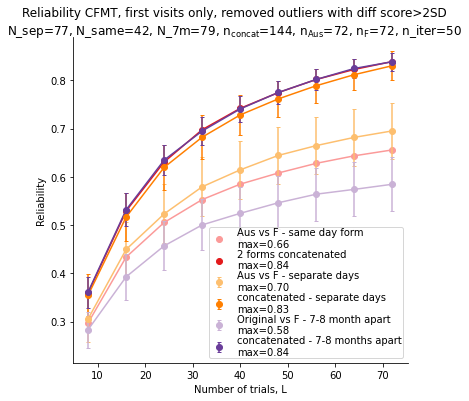

In [20]:
pallette_CFMT = sns.color_palette("Paired", n_colors=20, as_cmap=False)[4:]


fig, ax = plt.subplots(1,1, figsize=(6,6))
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_Aus2F2_nooutliers, n_trials_list_CFMT_Aus2F2_nooutliers, 'Aus vs F - same day'),
#     (array_corr_fxn_CFMT_AusF_nooutliers, n_trials_list_CFMT_AusF_nooutliers, 'Aus vs F - separate days'),
]):
    # plot Aus vs F
    ax.scatter(x_list, np.nanmean(arr, axis=1), label=f'{label} form\nmax={np.nanmean(arr, axis=1).max():.2f}', color=pallette_CFMT[2*i])
    ax.plot(x_list, np.nanmean(arr, axis=1), color=pallette_CFMT[2*i])

# add the full concatenated 2 forms
for i, (arr, x_list) in enumerate([
    (array_corr_fxn_CFMT_Aus2F2_concat_nooutliers, n_trials_list_CFMT_Aus2F2_concat_nooutliers),
#     (array_corr_fxn_CFMT_AusF_concat_nooutliers, n_trials_list_CFMT_AusF_concat_nooutliers),
]):
    
    ax.scatter(x_list, np.nanmean(arr, axis=1), label=f'2 forms concatenated\nmax={np.nanmean(arr, axis=1).max():.2f}', color=pallette_CFMT[2*i+1])
    ax.plot(x_list, np.nanmean(arr, axis=1), color=pallette_CFMT[2*i+1])

    
# # plot the sampled data
# for i, (arr, x_list, label) in enumerate([
#     (array_corr_fxn_CFMT_AusF_nooutliers_sampled, n_trials_list_CFMT_AusF_nooutliers_sampled, 'Aus vs F - separate days'),
#     (array_corr_fxn_CFMT_concat_AusF_nooutliers_sampled, n_trials_list_CFMT_concat_AusF_nooutliers_sampled, 'concatenated - separate days'),
# ]):
# #     ax.errorbar(x_list, np.nanmean(arr, axis=(-1,0)), yerr=error, fmt='o', capsize=2, c=pallette_CFMT[2*i+3], label=f'{label}')
#     # make first the nan
#     arr = np.nanmean(arr, axis=-1)
# #     print(arr.shape)
#     ax.errorbar(x_list, np.nanmean(arr, axis=0), yerr=np.nanstd(arr, axis=0), fmt='o', capsize=2, c=pallette_CFMT[9*i-2], label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}')
#     ax.plot(x_list, np.nanmean(arr, axis=0), color=pallette_CFMT[9*i-2])

# plot the sampled data
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_AusF_nooutliers_sampled, n_trials_list_CFMT_AusF_nooutliers_sampled, 'Aus vs F - separate days'),
    (array_corr_fxn_CFMT_concat_AusF_nooutliers_sampled, n_trials_list_CFMT_concat_AusF_nooutliers_sampled, 'concatenated - separate days'),
    (array_corr_fxn_CFMT_origFmonth_nooutliers_sampled, n_trials_list_CFMT_origFmonth_nooutliers_sampled, 'Original vs F - 7-8 month apart'),
    (array_corr_fxn_CFMT_concat_origFmonth_nooutliers_sampled, n_trials_list_CFMT_concat_origFmonth_nooutliers_sampled, 'concatenated - 7-8 months apart'),
]):
#     ax.errorbar(x_list, np.nanmean(arr, axis=(-1,0)), yerr=error, fmt='o', capsize=2, c=pallette_CFMT[2*i+3], label=f'{label}')
    # make first the nan
    arr = np.nanmean(arr, axis=-1)
#     print(arr.shape)
    ax.errorbar(x_list, np.nanmean(arr, axis=0), yerr=np.nanstd(arr, axis=0), fmt='o', capsize=2, c=pallette_CFMT[i+2], label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}')
    ax.plot(x_list, np.nanmean(arr, axis=0), color=pallette_CFMT[i+2])
    
    
ax.legend(loc="lower right", columnspacing=0.01, labelspacing=0.01, borderpad=0.05)

ax.set_ylabel('Reliability')
ax.set_xlabel('Number of trials, L')

sns.despine()

plt.suptitle(f"""Reliability CFMT, first visits only, removed outliers with diff score>{std_thr}SD
N_sep={N_CFMT_AusF_nooutliers}, N_same={N_CFMT_Aus2F2_nooutliers}, N_7m={N_CFMT_origFmonth_nooutliers}, n$_{{\mathrm{{concat}}}}$={total_n_trials_CFMT_Aus2F2_concat_nooutliers}, n$_{{\mathrm{{Aus}}}}$={total_n_trials_CFMT_Aus2_nooutliers}, n$_{{\mathrm{{F}}}}$={total_n_trials_CFMT_F2_nooutliers}, n_iter={N_iter_sampling}""", 
             y=.95)
# plt.suptitle(f'Reliability CFMT, first visits only, removed outliers with diff score>{std_thr}SD\nN_sep={N_CFMT_AusF_nooutliers}, N_same={N_CFMT_Aus2F2_nooutliers}, N_7m={N_CFMT_origFmonth_nooutliers}, n$_{{\mathrm{{concat}}}}$={total_n_trials_CFMT_Aus2F2_concat_nooutliers}, n$_{{\mathrm{{Aus}}}}$={total_n_trials_CFMT_Aus2_nooutliers}, n$_{{\mathrm{{F}}}}$={total_n_trials_CFMT_F2_nooutliers}', 

plt.show()

## Reliability stability across days - all tasks
[top](#top)

#### Load data
[top](#top)

In [21]:
task_files = [
 'CCMT-cleaned_data.csv',
 'CCMT-cleaned_data_rep.csv',
 'CFMT-cleaned_data.csv',
 'CFMT_Aus-cleaned_data.csv',
 'CFMT_Aus2-cleaned_data.csv',
 'CFMT_F-cleaned_data.csv',
 'CFMT_F2-cleaned_data.csv',
 'FMP-cleaned_data.csv',
 'FMP-cleaned_data_rep.csv',
 'GFMT-cleaned_data.csv',
 'GFMT-cleaned_data_rep.csv',
 'MST-cleaned_data.csv',
 'MST-cleaned_data_rep.csv',
 'PGNG-cleaned_data.csv',
 'PGNG-cleaned_data_rep.csv',
 'PIM_MC-cleaned_data.csv',
 'PIM_MC-cleaned_data_rep.csv',
 'PIM_recog-cleaned_data.csv',
 'PIM_recog-cleaned_data_rep.csv',
 'RISE-cleaned_data.csv',
 'SCAP-cleaned_data.csv',
 'SCAP-cleaned_data_rep.csv',
 'VET_birds-cleaned_data.csv',
 'VET_leaves-cleaned_data.csv',
 'VET_planes-cleaned_data.csv',
 'car_matching-cleaned_data.csv',
 'car_matching-cleaned_data_rep.csv',
 'emotion_labelling-cleaned_data.csv',
 'emotion_labelling_rep-cleaned_data.csv',
 'emotion_matching-cleaned_data.csv',
 'emotion_matching_rep-cleaned_data.csv',
 'nback-cleaned_data_day1.csv',
 'nback-cleaned_data_day2.csv'
]
print(len(task_files))

# check that they have the same length
assert len(sorted([x for x in os.listdir(csv_clean_data_path) if '-cleaned_data' in x]))-2 == len(task_files)


task_names = [
 'CCMT',
 'CFMT',
 'FMP',
 'GFMT',
 'MST',
 'PGNG',
 'PIM_MC',
 'PIM_recog',
 'RISE',
 'SCAP',
 'VET_birds',
 'VET_leaves',
 'VET_planes',
 'car_matching',
 'emotion_labelling',
 'emotion_matching',
 'nback',
]

print(f'Unique tasks: {len(task_names)}')

dataframe_list, dic_num_subjects_per_task, df_wide, df_normed_wide, completed_subjects, all_anything_subjects, VET_shared_subjects = process_and_concatenate_all_tasks(task_names, task_files, csv_clean_data_path)


33
Unique tasks: 17
CCMT
Running total 154 participants (out of 243 in first repetition).
CFMT
Running total 128 participants (out of 234 in first repetition).
FMP
Running total 119 participants (out of 223 in first repetition).
GFMT
Running total 157 participants (out of 238 in first repetition).
MST
Running total 84 participants (out of 231 in first repetition).
PGNG
Running total 152 participants (out of 237 in first repetition).
PIM_MC
Running total 152 participants (out of 249 in first repetition).
PIM_recog
Running total 152 participants (out of 249 in first repetition).
RISE
Running total 242 participants (out of 242 in first repetition).
SCAP
Running total 162 participants (out of 247 in first repetition).
VET_birds
Running total 118 participants (out of 118 in first repetition).
VET_leaves
Running total 119 participants (out of 119 in first repetition).
VET_planes
Running total 107 participants (out of 107 in first repetition).
car_matching
Running total 173 participants (out 

In [22]:
# define tasks that we want to check
task4analysis = [
 'CCMT',
#  'CFMT',
 'FMP',
 'GFMT',
 'MST',
 'PGNG',
 'PIM_MC',
#  'PIM_recog',
#  'RISE', # does not have 2 days
 'SCAP',
#  'VET_birds',
#  'VET_leaves',
#  'VET_planes',
 'car_matching',
 'emotion_labelling',
 'emotion_matching',
#  'nback',
#  'nback_lvl2',
]


In [23]:
# task4analysis_wo_nback = [x for x in task4analysis if 'nback' not in x]

# from itertools import product

difference_conditions = ('2SD',)
performance_conditions = (None,)

cleaning_conditions = list(product(difference_conditions, performance_conditions))
cleaning_conditions

[('2SD', None)]

In [24]:
# define dic to save data to
dic_reliability_arrays_nooutliers = {}

# how many samples we want to correlate
n_repeats = 10**3

# flag for running also the individual days -- longer and not necessary but good at the beginning for quality check
run_short_arrays = True

# start the timer
start = time.time()

# run without nback as it is not behaving well
for task in task4analysis:
    
    # start the timer
    start_task = time.time()
    
    # be sure and clean
    df_temp = None
    df_temp_cleaned = None
    print(task)
    # extract data
    if task == "nback_lvl2":
        df_temp = [x for x in dataframe_list if x.task.str.contains('nback').all()][0]
        df_temp = df_temp.loc[df_temp["level"]==2]
    else:
        df_temp = [x for x in dataframe_list if x.task.str.contains(task).all()][0]

    if task == "PIM_MC":
        # merge and flat all the cols
        df_temp = pd.melt(df_temp[['userID', 'hobby', 'vice', 'code_name', 'country', 'form']], 
                          id_vars=['userID', 'form'], value_name='correct')
    
    # check that the forms are there
    assert set(["original", "repetition"]) == set(df_temp["form"].unique())
    print(f"Starting with N={df_temp['userID'].unique().size} subjects.")
    
    # define dic, make sure I'm not overwriting it
    if task not in dic_reliability_arrays_nooutliers.keys():
        dic_reliability_arrays_nooutliers[task] = {}
    
    # go over all conditions of cleaning
    for diff_c, perf_c in cleaning_conditions:
        # copy the df to be able to clean it
        df_temp_cleaned = df_temp.copy()
        
        # define condition
        condition = f'diff:{diff_c}, perf:{perf_c}'
        print(condition)
        
        # define outliers that we want to drop on accuracy
        if perf_c is not None:
            # check if it's SD or %
            if 'SD' in perf_c:
                # find the SD and select the SD
                std_thr_acc = float(perf_c.strip('SD'))
                # add label
                condition += '_bottom'
                           
                for form in ["original", "repetition"]:        
                    # compute the mean, use the original dataset and not the one that will already be partially cleaned
                    tmp_series = df_temp.loc[df_temp["form"]==form].groupby(['userID']).correct.mean()
                    mu_acc = tmp_series.mean() #df_temp['correct'].mean()
                    std_acc = tmp_series.std() #df_temp.groupby(['userID']).correct.mean().std()
                    outliers_acc = set(tmp_series[tmp_series<mu_acc-std_acc*std_thr_acc].dropna().index)
                    # drop the outliers form the cleaned dataset
                    df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers_acc)]
                    print(f'Dropping {len(outliers_acc)} outliers for accuracy in {form}')
            
            elif '%' in perf_c:
                # drop the perf_c percent of the scores
                std_thr_acc = float(perf_c.strip('%'))/100
                for form in ["original", "repetition"]:        
                    # take the n smallest scores where n is proportional to the threshold
                    outliers_acc = tmp_series.nsmallest(int(np.round(len(tmp_series)*std_thr_acc))).index
                    # drop the outliers form the cleaned dataset
                    df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers_acc)]
                    print(f'Dropping {len(outliers_acc)} outliers for accuracy in {form}')
                    
            else:
                raise ValueError(f'Provided value cannot be processed: {perf_c}')
        
        # there is no else because if it is None, then we are not cleaning which means that we continue with the original dataset
                
        
        # define outliers that we want to drop on score difference between visits
        if diff_c is not None:            
            # compute the score difference
            tmp_score_diff = df_temp_cleaned.loc[df_temp_cleaned["form"]=="original", ["userID", "correct"]].groupby('userID').mean() - df_temp_cleaned.loc[df_temp_cleaned["form"]=="repetition", ["userID", "correct"]].groupby('userID').mean()

            # check if it's SD or %
            if 'SD' in diff_c:
                std_thr = float(diff_c.strip('SD'))
                # drop participants whose difference in score on first and second step is large
                mu = tmp_score_diff.mean()[0]
                std = tmp_score_diff.std()[0]
                outliers = set(tmp_score_diff[tmp_score_diff<mu-std*std_thr].dropna().index)|set(tmp_score_diff[tmp_score_diff>mu+std*std_thr].dropna().index)
                df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers)]
                
            elif '%' in diff_c:
                # drop the perf_c percent of the scores
                std_thr = float(diff_c.strip('%'))/100
                
                # take the n larges differences in scores where n is proportional to the threshold
                outliers = tmp_score_diff.abs().nlargest(int(np.round(len(tmp_score_diff)*std_thr)), 'correct').index
                # drop the outliers form the cleaned dataset
                df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers)]
                
                
            print(f'Dropping {len(outliers)} outliers for score difference')
        

        # extract to arrays
        N_temp = df_temp_cleaned['userID'].unique().size

        ## original
        # max number of trials
        total_n_trials_orig = check_df_get_numbers(df_temp_cleaned.loc[df_temp_cleaned["form"]=="original", ['userID', 'correct']], N_temp)
        # extract the data
        all_trials_reshaped_orig = extract_data(df_temp_cleaned.loc[df_temp_cleaned["form"]=="original", ['userID', 'correct']], total_n_trials_orig, measure="correct")

        ## repetition
        # max number of trials
        total_n_trials_rep = check_df_get_numbers(df_temp_cleaned.loc[df_temp_cleaned["form"]=="repetition", ['userID', 'correct']], N_temp)
        # extract the data
        all_trials_reshaped_rep = extract_data(df_temp_cleaned.loc[df_temp_cleaned["form"]=="repetition", ['userID', 'correct']], total_n_trials_rep, measure="correct")


        ## concat
        # max number of trials
        total_n_trials_concat = check_df_get_numbers(df_temp_cleaned.loc[:, ['userID', 'correct']], N_temp)
        # extract the data
        all_trials_reshaped_concat = extract_data(df_temp_cleaned.loc[:, ['userID', 'correct']], total_n_trials_concat, measure="correct")


        ### Run analysis
        ## Short arrays
        if run_short_arrays:
            if task == 'nback':
                step = 6
            else:
                step = None
            array_corr_fxn_orig, n_trials_list_orig = calculate_reliability_between_two_groups(all_trials_reshaped_orig, all_trials_reshaped_orig, total_n_trials_orig, step=step)
            array_corr_fxn_rep, n_trials_list_rep = calculate_reliability_between_two_groups(all_trials_reshaped_rep, all_trials_reshaped_rep, total_n_trials_rep, step=step)


        #### for MST, increase the step size, it's too slow and anyway not needed
        if task == 'MST':
            step = 10
        else:
            step = None
        ## Long arrays
        array_corr_fxn_orig_vs_rep, n_trials_list_orig_vs_rep = calculate_reliability_between_two_groups(all_trials_reshaped_orig, all_trials_reshaped_rep, total_n_trials_orig+total_n_trials_rep, step=step)

        # and concat days
        array_corr_fxn_concat, n_trials_list_concat = calculate_reliability_between_two_groups(all_trials_reshaped_concat, all_trials_reshaped_concat, total_n_trials_concat, step=step)


        ### save data
        dic_reliability_arrays_nooutliers[task][condition] = {
            'N': N_temp,
            'task': task,
            'total_n_trials_orig': total_n_trials_orig,
            'total_n_trials_rep': total_n_trials_rep,
            'total_n_trials_concat': total_n_trials_concat,
            'all_trials_reshaped_orig': all_trials_reshaped_orig,
            'all_trials_reshaped_rep': all_trials_reshaped_rep,
            'all_trials_reshaped_concat': all_trials_reshaped_concat,
            'array_corr_fxn_orig_vs_rep': array_corr_fxn_orig_vs_rep,
            'array_corr_fxn_concat': array_corr_fxn_concat,
            'n_trials_list_orig_vs_rep': n_trials_list_orig_vs_rep,
            'n_trials_list_concat': n_trials_list_concat,
        }

        if run_short_arrays:
            dic_reliability_arrays_nooutliers[task][condition]['array_corr_fxn_orig'] = array_corr_fxn_orig
            dic_reliability_arrays_nooutliers[task][condition]['array_corr_fxn_rep'] = array_corr_fxn_rep
            dic_reliability_arrays_nooutliers[task][condition]['n_trials_list_orig'] = n_trials_list_orig
            dic_reliability_arrays_nooutliers[task][condition]['n_trials_list_rep'] = n_trials_list_rep
        
    #
    print(f"Task took: {time.time() - start_task:.2f} s which is {(time.time() - start_task) / 60:.2f} min.\n")
    
    
print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")

CCMT
Starting with N=154 subjects.
diff:2SD, perf:None
Dropping 6 outliers for score difference
Total number of trials is 72.
Total number of trials is 72.
Total number of trials is 144.
Process took: 5.65 s which is 0.09 min.
Process took: 5.60 s which is 0.09 min.
Process took: 4.50 s which is 0.07 min.
Process took: 4.83 s which is 0.08 min.
Task took: 21.14 s which is 0.35 min.

FMP
Starting with N=119 subjects.
diff:2SD, perf:None
Dropping 3 outliers for score difference
Total number of trials is 180.
Total number of trials is 180.
Total number of trials is 360.
Process took: 6.67 s which is 0.11 min.
Process took: 6.52 s which is 0.11 min.
Process took: 14.02 s which is 0.23 min.
Process took: 15.84 s which is 0.26 min.
Task took: 43.73 s which is 0.73 min.

GFMT
Starting with N=157 subjects.
diff:2SD, perf:None
Dropping 6 outliers for score difference
Total number of trials is 40.
Total number of trials is 40.
Total number of trials is 80.
Process took: 2.93 s which is 0.05 min.

/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Figures/../Code/functions/reliability_functions.py:591: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_first[:, random_idx], axis=1),
/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Figures/../Code/functions/reliability_functions.py:592: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_second[:, random_idx2], axis=1)


Process took: 5.83 s which is 0.10 min.
Process took: 5.76 s which is 0.10 min.
Process took: 4.48 s which is 0.07 min.
Process took: 4.89 s which is 0.08 min.
Task took: 21.52 s which is 0.36 min.

car_matching
Starting with N=173 subjects.
diff:2SD, perf:None
Dropping 9 outliers for score difference
Total number of trials is 40.
Total number of trials is 40.
Total number of trials is 80.
Process took: 2.86 s which is 0.05 min.
Process took: 3.05 s which is 0.05 min.
Process took: 6.83 s which is 0.11 min.
Process took: 6.41 s which is 0.11 min.
Task took: 19.57 s which is 0.33 min.

emotion_labelling
Starting with N=166 subjects.
diff:2SD, perf:None
Dropping 7 outliers for score difference
Total number of trials is 45.
Total number of trials is 45.
Total number of trials is 90.


/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Figures/../Code/functions/reliability_functions.py:592: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_second[:, random_idx2], axis=1)
/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Figures/../Code/functions/reliability_functions.py:591: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_first[:, random_idx], axis=1),


Process took: 3.36 s which is 0.06 min.
Process took: 3.70 s which is 0.06 min.
Process took: 7.44 s which is 0.12 min.
Process took: 7.59 s which is 0.13 min.
Task took: 22.51 s which is 0.38 min.

emotion_matching
Starting with N=161 subjects.
diff:2SD, perf:None
Dropping 8 outliers for score difference
Total number of trials is 61.
Total number of trials is 61.
Total number of trials is 122.


/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Figures/../Code/functions/reliability_functions.py:591: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_first[:, random_idx], axis=1),
/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Figures/../Code/functions/reliability_functions.py:592: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_second[:, random_idx2], axis=1)


Process took: 4.74 s which is 0.08 min.
Process took: 4.41 s which is 0.07 min.
Process took: 4.23 s which is 0.07 min.
Process took: 4.19 s which is 0.07 min.
Task took: 18.10 s which is 0.30 min.

Process took: 271.18 s which is 4.52 min.



## CanD
[top](#top)

In [25]:
sns.blend_palette([(0.527379132958601, 0.7533869223064523, 0.976093642396389), (0,0,1)], n_colors=9)

[(0.527379132958601, 0.7533869223064523, 0.976093642396389),
 (0.46119822215595296, 0.6588442497032897, 0.9790936558995872),
 (0.39501731135330503, 0.5643015771001271, 0.9820936694027854),
 (0.3288364005506571, 0.4697589044969644, 0.9850936829059838),
 (0.2626554897480091, 0.37521623189380177, 0.988093696409182),
 (0.19647457894536113, 0.2806735592906391, 0.9910937099123802),
 (0.1302936681427132, 0.18613088668747646, 0.9940937234155784),
 (0.06411275734006522, 0.09158821408431383, 0.9970937369187767),
 (0.0, 0.0, 1.0)]

In [26]:
sns.color_palette('blend:deepskyblue,blue', desat=.8, n_colors=12)

[(0.09999999999999998, 0.6992156862745098, 0.9),
 (0.09999999999999998, 0.6451687812379853, 0.9),
 (0.09999999999999998, 0.5911218762014612, 0.9),
 (0.09999999999999998, 0.5370749711649365, 0.9),
 (0.09999999999999998, 0.48067820069204126, 0.9),
 (0.09999999999999998, 0.42663129565551666, 0.9),
 (0.09999999999999998, 0.3725843906189926, 0.9),
 (0.09999999999999998, 0.31853748558246797, 0.9),
 (0.09999999999999998, 0.2621407151095727, 0.9),
 (0.09999999999999998, 0.2080938100730492, 0.9),
 (0.09999999999999998, 0.15404690503652457, 0.9),
 (0.09999999999999998, 0.09999999999999998, 0.9)]

In [27]:
sns.color_palette('blend:lightskyblue,navy', desat=.8, n_colors=12)

[(0.5745098039215685, 0.7972549019607844, 0.9352941176470589),
 (0.5272187620146097, 0.7298731257208766, 0.891681660899654),
 (0.47992772010765083, 0.6624913494809688, 0.8480692041522491),
 (0.43263667820069207, 0.595109573241061, 0.8044567474048443),
 (0.38328950403690887, 0.5247981545559398, 0.7589480968858131),
 (0.3359984621299499, 0.45741637831603216, 0.7153356401384083),
 (0.2887074202229911, 0.3900346020761244, 0.6717231833910035),
 (0.24141637831603235, 0.32265282583621707, 0.6281107266435986),
 (0.19206920415224915, 0.2523414071510958, 0.5826020761245674),
 (0.14477816224529028, 0.18495963091118797, 0.5389896193771626),
 (0.09748712033833146, 0.11757785467128028, 0.4953771626297578),
 (0.050196078431372526, 0.050196078431372526, 0.45176470588235296)]

In [28]:
sns.color_palette('light:dodgerblue', desat=1, n_colors=9)#[4]

[(0.9403374438978855, 0.943553639739912, 0.9519990457565293),
 (0.8370978661630645, 0.8960119603815471, 0.9580226949164942),
 (0.7338582884282432, 0.848470281023182, 0.9640463440764591),
 (0.6306187106934221, 0.8009286016648172, 0.9700699932364242),
 (0.527379132958601, 0.7533869223064523, 0.976093642396389),
 (0.42413955522377966, 0.7058452429480873, 0.9821172915563541),
 (0.3208999774889585, 0.6583035635897219, 0.9881409407163191),
 (0.2176603997541373, 0.6107618842313567, 0.9941645898762841),
 (0.11764705882352944, 0.5647058823529412, 1.0)]

In [29]:
sns.color_palette('PuBu_r', n_colors=9, desat=1)

[(0.013994617454825109, 0.3241830065359477, 0.5081122645136487),
 (0.018039215686274535, 0.404705882352941, 0.6352941176470588),
 (0.09345636293733184, 0.48744329104190687, 0.7143098808150711),
 (0.260392156862745, 0.5843137254901958, 0.7647058823529411),
 (0.45797770088427525, 0.6639753940792004, 0.8125028835063438),
 (0.611764705882353, 0.7254901960784313, 0.8494117647058823),
 (0.7523875432525953, 0.7894655901576317, 0.8853825451749326),
 (0.859607843137255, 0.8541176470588236, 0.9207843137254901),
 (0.9415609381007305, 0.9194156093810074, 0.9566320645905421)]

In [30]:
sns.color_palette('Blues')

[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]

In [31]:
sns.cubehelix_palette(n_colors=9, start=2.5)

[[0.9277478576287002, 0.8033426205150684, 0.8971272728480323],
 [0.8563079636791993, 0.7011533167378441, 0.8557562915752576],
 [0.7586072847989257, 0.6059944531292277, 0.8126460806303218],
 [0.647347280000844, 0.5258026556924874, 0.7618883365215956],
 [0.5253643433157242, 0.4541197811040302, 0.6947359851470578],
 [0.39523968318288416, 0.38453202490743055, 0.6029000957324522],
 [0.27721778134893976, 0.3185771584971031, 0.49422176667536727],
 [0.16920631714622203, 0.24512728257126792, 0.36279215157720285],
 [0.08677788912469225, 0.16607394209474732, 0.22729635328913061]]

In [32]:
# sns.choose_cubehelix_palette()

{'name': 'Arial'}
Reliability longitudinal FMP, N=183, removed outliers >2SD
Reliability CFMT, Female and Australian version, first visits only, removed outliers with diff score>2.0SD
N_sep=77, N_same=42, N_7m=79, n$_{\mathrm{concat}}$=144, n$_{\mathrm{Aus}}$=72, n$_{\mathrm{F}}$=72, n_iter=50


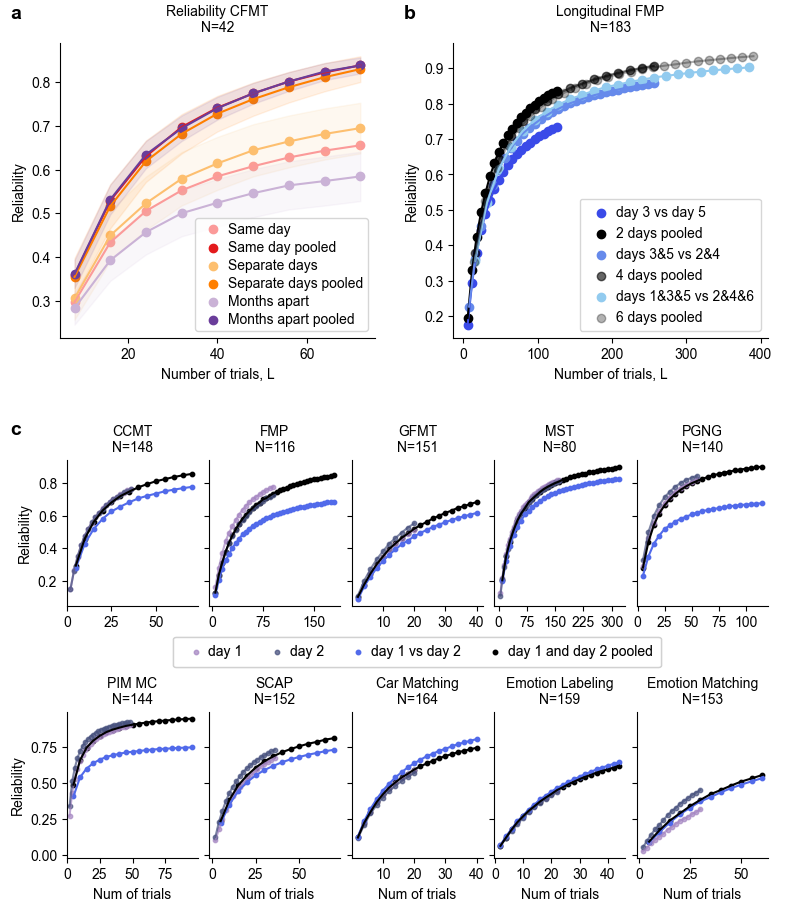

In [60]:
#######################
# define canvas

from cand import Canvas, Vector, Point
import matplotlib.ticker as ticker

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=10


# CanD
a = 20
b = 13+10
# rot = 15
c = Canvas(a, b, "cm")

# set font
# c.set_font("Helvetica", size=10)
c.set_font("Arial", size=10)

# letters
# c.add_text("A", Point(.05, 0.98), weight="bold")
c.add_text("a", Point(.02, 0.985), weight="bold", size=font_size)
c.add_text("b", Point(.52, 0.985), weight="bold", size=font_size)
c.add_text("c", Point(.02, 0.525), weight="bold", size=font_size)
           
# titles
titles = [f'Reliability longitudinal FMP, N={N_FMP_long_nooutliers_all_days}, removed outliers >2SD', f"""Reliability CFMT, Female and Australian version, first visits only, removed outliers with diff score>{std_thr}SD
N_sep={N_CFMT_AusF_nooutliers}, N_same={N_CFMT_Aus2F2_nooutliers}, N_7m={N_CFMT_origFmonth_nooutliers}, n$_{{\mathrm{{concat}}}}$={total_n_trials_CFMT_Aus2F2_concat_nooutliers}, n$_{{\mathrm{{Aus}}}}$={total_n_trials_CFMT_Aus2_nooutliers}, n$_{{\mathrm{{F}}}}$={total_n_trials_CFMT_F2_nooutliers}, n_iter={N_iter_sampling}"""]
# c.add_text(titles[0], Point(.27, 0.947), size=font_size)
for title in titles:
    print(title)

# ### GRID
# # top row, panels A, B
top_offset = 1.1#5
bottom_offset = 1.6#5
bottom_offset_tasks = 1.2

middle = 12.8

# add a 1x2 grid
left_offset = 1.53
hsb = 2.4 #half_space_between - horizontal
vsb = 2 #half_space_between - vertical
# c.add_grid(["CFMT", "FMP"], 1, Point(left_offset, bottom_offset, "cm"), Point(a-0.5, b-top_offset, "cm"), spacing=Vector(vsb, hsb, "cm"), unitname="grid")
# c.add_grid(["CFMT", "FMP"], 1, Point(left_offset, bottom_offset, "cm"), Point(a-0.5, b-middle-4*top_offset, "cm"), spacing=Vector(vsb, hsb, "cm"))
c.add_grid(["CFMT", "FMP"], 1, Point(left_offset, middle+bottom_offset, "cm"), Point(a-0.5, b-top_offset, "cm"), spacing=Vector(vsb, hsb, "cm"))


# # bottom row, panel C
left_offset_tasks = 1.7
hsb_tasks = 2.7 #half_space_between - horizontal
vsb_tasks = .3 #half_space_between - vertical

# add a 2x5 grid
c.add_grid([f"p{i}" for i in range(len(task4analysis))], 2, Point(left_offset_tasks, bottom_offset_tasks, "cm"), Point(a-0.5, b-middle+top_offset, "cm"), spacing=Vector(vsb_tasks, hsb_tasks, "cm"), unitname="grid")



# define colours
# palette = sns.color_palette("bright", n_colors=4, as_cmap=False)
# colour_day3and5 = colour_day1#palette[1]
# colour_day35and24 = palette[1]#palette[2]
# colour_day135and246 = colour_day1vsday#palette[3]
# palette = sns.cubehelix_palette(n_colors=9, start=2.5)
# palette = sns.color_palette('Blues', n_colors=9)
palette = sns.color_palette('blend:lightskyblue,blue', desat=.8, n_colors=12)
colour_day3and5 = palette[8]
colour_day35and24 = palette[4]
colour_day135and246 = palette[0]

# palette_tasks = sns.color_palette("bright", n_colors=len(task4analysis), as_cmap=False)
palette_tasks = sns.cubehelix_palette(n_colors=9, start=2.5)
colour_day1 = palette_tasks[3]#'cornflowerblue'#palette_tasks[6]
colour_day2 = palette_tasks[6]#palette_tasks[9]#'saddlebrown'#palette_tasks[2]
colour_day1vsday = palette[6]#'cornflowerblue'#palette[6]#palette_tasks[0]



pallette_CFMT = sns.color_palette("Paired", n_colors=20, as_cmap=False)[4:]
# pallette_CFMT_same = [pallette_CFMT[4], pallette_CFMT[5]]
pallette_CFMT_separate = pallette_CFMT[2:]


# define if to plot the error in CFMT
plot_error = True


############################ PLOT CFMT
# plot same day, Aus2 vs F2
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_Aus2F2_nooutliers, n_trials_list_CFMT_Aus2F2_nooutliers, 'Same day'),
    (array_corr_fxn_CFMT_Aus2F2_concat_nooutliers, n_trials_list_CFMT_Aus2F2_concat_nooutliers, 'Same day pooled'),
]):
    c.ax('CFMT').scatter(x_list, np.nanmean(arr, axis=1), label=f'{label}', color=pallette_CFMT[i])
    c.ax('CFMT').plot(x_list, np.nanmean(arr, axis=1), color=pallette_CFMT[i])

# plot the sampled data
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_AusF_nooutliers_sampled, n_trials_list_CFMT_AusF_nooutliers_sampled, 'Separate days'),
    (array_corr_fxn_CFMT_concat_AusF_nooutliers_sampled, n_trials_list_CFMT_concat_AusF_nooutliers_sampled, 'Separate days pooled'),
    (array_corr_fxn_CFMT_origFmonth_nooutliers_sampled, n_trials_list_CFMT_origFmonth_nooutliers_sampled, 'Months apart'),
    (array_corr_fxn_CFMT_concat_origFmonth_nooutliers_sampled, n_trials_list_CFMT_concat_origFmonth_nooutliers_sampled, 'Months apart pooled'),
]):
    # make first the nan
    arr = np.nanmean(arr, axis=-1)
#     c.ax('CFMT').errorbar(x_list, np.nanmean(arr, axis=0), yerr=np.nanstd(arr, axis=0), fmt='o', capsize=2, c=pallette_CFMT[i+2], label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}')
    c.ax('CFMT').plot(x_list, np.nanmean(arr, axis=0), color=pallette_CFMT_separate[i])
    c.ax('CFMT').scatter(x_list, np.nanmean(arr, axis=0), color=pallette_CFMT_separate[i], label=f'{label}')
    
    if plot_error:
        c.ax('CFMT').fill_between(
            x_list,
            np.nanmean(arr, axis=0)-np.nanstd(arr, axis=0),
            np.nanmean(arr, axis=0)+np.nanstd(arr, axis=0),
    #         label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}',
            color=pallette_CFMT_separate[i], alpha=0.1,
        )
    
c.ax('CFMT').legend(loc="lower right", columnspacing=0.01, labelspacing=0.3, borderpad=0.3, handletextpad=0.1)

c.ax('CFMT').set_ylabel('Reliability')
c.ax('CFMT').set_xlabel('Number of trials, L')

c.add_text(f"Reliability CFMT\nN={min(N_CFMT_AusF_nooutliers, N_CFMT_Aus2F2_nooutliers, N_CFMT_origFmonth_nooutliers)}", 
           Point(.5, 1.08, "axis_CFMT"))


############################ PLOT FMP
c.ax('FMP').scatter(n_trials_list_day3vs5_nooutliers, np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1), label=f'day 3 vs day 5', color=colour_day3and5)
c.ax('FMP').plot(n_trials_list_day3vs5_nooutliers, np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1), color=colour_day3and5)

# add the full concatenated 2 forms
c.ax('FMP').scatter(n_trials_list_day3and5_concat_nooutliers, np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1), label=f'2 days pooled', color='k')
c.ax('FMP').plot(n_trials_list_day3and5_concat_nooutliers, np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1), color='k')


#######
c.ax('FMP').scatter(n_trials_list_day35vs24_nooutliers, np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1), label=f'days 3&5 vs 2&4', color=colour_day35and24)
c.ax('FMP').plot(n_trials_list_day35vs24_nooutliers, np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1), color=colour_day35and24)

# add the full concatenated 4 forms
c.ax('FMP').scatter(n_trials_list_day2345_concat_nooutliers, np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1), label=f'4 days pooled', color='k', alpha=0.6)
c.ax('FMP').plot(n_trials_list_day2345_concat_nooutliers, np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1), color='k', alpha=0.6)


#######
c.ax('FMP').scatter(n_trials_list_day135vs246_nooutliers, np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1), label=f'days 1&3&5 vs 2&4&6', color=colour_day135and246)
c.ax('FMP').plot(n_trials_list_day135vs246_nooutliers, np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1), color=colour_day135and246)

# add the full concatenated 6 forms
c.ax('FMP').scatter(n_trials_list_alldays_concat_nooutliers, np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1), label=f'6 days pooled', color='k', alpha=0.3)
c.ax('FMP').plot(n_trials_list_alldays_concat_nooutliers, np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1), color='k', alpha=0.3)


## polish
c.ax('FMP').legend(loc="lower right", columnspacing=0.01, labelspacing=.5, borderpad=0.5, handletextpad=0.1)

c.ax('FMP').set_ylabel('Reliability')
c.ax('FMP').set_xlabel('Number of trials, L')

c.add_text(f"Longitudinal FMP\nN={N_FMP_long_nooutliers_all_days}", Point(.5, 1.08, "axis_FMP"))


######### panel C
# for (i, ax), task in zip(enumerate(c.axes.values()), task4analysis):
for i, task in enumerate(task4analysis):
    ax = c.ax(f'p{i}')
    # select the corresponding dic -- choose task and cleaning condition
    tmp_dic = dic_reliability_arrays_nooutliers[task]['diff:2SD, perf:None']

    # plot first the single days
    if run_short_arrays:
        ## plot short arrays
        ax.scatter(tmp_dic['n_trials_list_orig'], np.nanmean(tmp_dic['array_corr_fxn_orig'], axis=1), color=colour_day1, alpha=0.7, label=f'original\nmax={np.nanmean(tmp_dic["array_corr_fxn_orig"], axis=1).max():.2f}', s=10)
        ax.plot(tmp_dic['n_trials_list_orig'], np.nanmean(tmp_dic['array_corr_fxn_orig'], axis=1), color=colour_day1, alpha=0.7)
        # plot rep days
        ax.scatter(tmp_dic['n_trials_list_rep'], np.nanmean(tmp_dic['array_corr_fxn_rep'], axis=1), color=colour_day2, alpha=0.7, label=f'repetition\nmax={np.nanmean(tmp_dic["array_corr_fxn_rep"], axis=1).max():.2f}', s=10)
        ax.plot(tmp_dic['n_trials_list_rep'], np.nanmean(tmp_dic['array_corr_fxn_rep'], axis=1), color=colour_day2, alpha=0.7)


    ## plot long arrays
    ax.scatter(tmp_dic['n_trials_list_orig_vs_rep'], np.nanmean(tmp_dic['array_corr_fxn_orig_vs_rep'], axis=1), label=f'day 1 vs day 2\nmax={np.nanmean(tmp_dic["array_corr_fxn_orig_vs_rep"], axis=1).max():.2f}', color=colour_day1vsday, s=10)
    ax.plot(tmp_dic['n_trials_list_orig_vs_rep'], np.nanmean(tmp_dic['array_corr_fxn_orig_vs_rep'], axis=1), color=colour_day1vsday)

    # add the full concatenated forms
    ax.scatter(tmp_dic['n_trials_list_concat'], np.nanmean(tmp_dic['array_corr_fxn_concat'], axis=1), label=f'concatenated days\nmax={np.nanmean(tmp_dic["array_corr_fxn_concat"], axis=1).max():.2f}', color='k', s=10, zorder=0)
    ax.plot(tmp_dic['n_trials_list_concat'], np.nanmean(tmp_dic['array_corr_fxn_concat'], axis=1), color='k')

    
    ax_title = task.replace("_", " ").replace("pseudoslopes", "").replace("concat", "").replace("labelling", "labeling").replace("faces-perc", "\ninterference - FM").replace("faces", "interference").replace("blank", "delay").replace("perception", "face matching").replace(" birds planes leaves", "").replace("n back", "N Back").replace("nback  level2 d prime", "N Back d'")
    if 'emotion' in ax_title or 'car' in ax_title:
        ax_title = ax_title.title() 
#     ax.set_title(ax_title)
    ax.set_title(f'{ax_title}\nN={tmp_dic["N"]}')
#     c.add_text(f'{ax_title}\nN={tmp_dic["N"]}', Point(.5, 1.1, f"p{i}"))
    
    # make sure it starts at 0
    ax.set_xlim(left=0)
    
    # adjust xticks spacing
    x = tmp_dic['n_trials_list_concat']
    if x.max()<=50:
        ax.xaxis.set_ticks(np.arange(0, x.max()+11, 10))
#         ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
        
    elif x.max()<=120:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
    else:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(75))
    
    # deal with labels
    if i>= len(task4analysis)-5:
        ax.set_xlabel("Num of trials")
    else:
        ax.set_xlabel("")
    
    if i%5==0:
        ax.set_ylabel("Reliability")
        source_ax = ax
    else:
        #ax.set_ylabel("")
        sharey_ax(ax, source_ax)
    
    # legend loc
    if i == 2:
        legend1 = ax.legend(ax.get_legend_handles_labels()[0],
                            ['day 1', 'day 2', 'day 1 vs day 2', 'day 1 and day 2 pooled'], bbox_to_anchor=(0.5,-.47),
                            borderpad=0.6, handletextpad=-.1, columnspacing=1.5, loc='lower center', ncols=4,
                            fontsize=legend_size, labelspacing=0.6)
        ax.add_artist(legend1)
        
        



### make it nice
for ax in c.axes.values():
    sns.despine(ax=ax)

    
## --------------------------------------------------    
    
# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
#
c.save(os.path.join(path_figures, "Fig4", 'Figure_4.png'), dpi=300)#, bbox_inches="tight")
c.save(os.path.join(path_figures, "Fig4", 'Figure_4.pdf'), dpi=300)#, bbox_inches="tight")

#### Switch order of panels

{'name': 'Arial'}
Reliability longitudinal FMP, N=183, removed outliers >2SD
Reliability CFMT, Female and Australian version, first visits only, removed outliers with diff score>2.0SD
N_sep=77, N_same=42, N_7m=79, n$_{\mathrm{concat}}$=144, n$_{\mathrm{Aus}}$=72, n$_{\mathrm{F}}$=72, n_iter=50


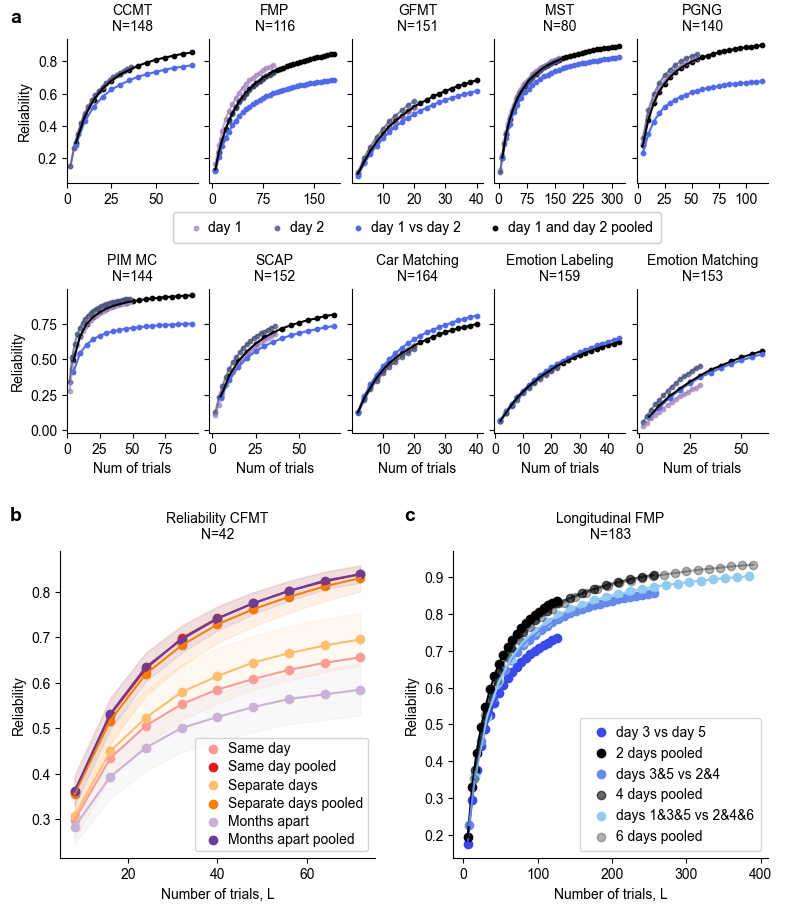

In [61]:
#######################
# define canvas

from cand import Canvas, Vector, Point
import matplotlib.ticker as ticker

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=10


# CanD
a = 20
b = 13+10
# rot = 15
c = Canvas(a, b, "cm")

# set font
# c.set_font("Helvetica", size=10)
c.set_font("Arial", size=10)

# letters
# c.add_text("A", Point(.05, 0.98), weight="bold")
c.add_text("a", Point(.02, 0.98), weight="bold", size=font_size)
c.add_text("b", Point(.02, 0.43), weight="bold", size=font_size)
c.add_text("c", Point(.52, 0.43), weight="bold", size=font_size)
           
# titles
titles = [f'Reliability longitudinal FMP, N={N_FMP_long_nooutliers_all_days}, removed outliers >2SD', f"""Reliability CFMT, Female and Australian version, first visits only, removed outliers with diff score>{std_thr}SD
N_sep={N_CFMT_AusF_nooutliers}, N_same={N_CFMT_Aus2F2_nooutliers}, N_7m={N_CFMT_origFmonth_nooutliers}, n$_{{\mathrm{{concat}}}}$={total_n_trials_CFMT_Aus2F2_concat_nooutliers}, n$_{{\mathrm{{Aus}}}}$={total_n_trials_CFMT_Aus2_nooutliers}, n$_{{\mathrm{{F}}}}$={total_n_trials_CFMT_F2_nooutliers}, n_iter={N_iter_sampling}"""]
# c.add_text(titles[0], Point(.27, 0.947), size=font_size)
for title in titles:
    print(title)

# ### GRID
# # top row, panel A
top_offset = 1.#5
bottom_offset_tasks = 2#5
bottom_offset = 1.2

middle = 10

left_offset_tasks = 1.7
hsb_tasks = 2.7 #half_space_between - horizontal
vsb_tasks = .3 #half_space_between - vertical

# add a 2x5 grid
c.add_grid([f"p{i}" for i in range(len(task4analysis))], 2, Point(left_offset_tasks, middle+bottom_offset_tasks, "cm"), Point(a-0.5, b-top_offset, "cm"), spacing=Vector(vsb_tasks, hsb_tasks, "cm"), unitname="grid")

# # bottom row, panels B, C
# add a 1x2 grid
left_offset = 1.53
hsb = 2.4 #half_space_between - horizontal
vsb = 2 #half_space_between - vertical
# c.add_grid(["CFMT", "FMP"], 1, Point(left_offset, bottom_offset, "cm"), Point(a-0.5, b-top_offset, "cm"), spacing=Vector(vsb, hsb, "cm"), unitname="grid")
c.add_grid(["CFMT", "FMP"], 1, Point(left_offset, bottom_offset, "cm"), Point(a-0.5, b-middle-4*top_offset, "cm"), spacing=Vector(vsb, hsb, "cm"))


# define colours
# palette = sns.color_palette("bright", n_colors=4, as_cmap=False)
# colour_day3and5 = colour_day1#palette[1]
# colour_day35and24 = palette[1]#palette[2]
# colour_day135and246 = colour_day1vsday#palette[3]
# palette = sns.cubehelix_palette(n_colors=9, start=2.5)
# palette = sns.color_palette('Blues', n_colors=9)
palette = sns.color_palette('blend:lightskyblue,blue', desat=.8, n_colors=12)
colour_day3and5 = palette[8]
colour_day35and24 = palette[4]
colour_day135and246 = palette[0]

# palette_tasks = sns.color_palette("bright", n_colors=len(task4analysis), as_cmap=False)
palette_tasks = sns.cubehelix_palette(n_colors=9, start=2.5)
colour_day1 = palette_tasks[3]#'cornflowerblue'#palette_tasks[6]
colour_day2 = palette_tasks[6]#palette_tasks[9]#'saddlebrown'#palette_tasks[2]
colour_day1vsday = palette[6]#'cornflowerblue'#palette[6]#palette_tasks[0]



pallette_CFMT = sns.color_palette("Paired", n_colors=20, as_cmap=False)[4:]
# pallette_CFMT_same = [pallette_CFMT[4], pallette_CFMT[5]]
pallette_CFMT_separate = pallette_CFMT[2:]


# define if to plot the error in CFMT
plot_error = True

######### panel A
for (i, ax), task in zip(enumerate(c.axes.values()), task4analysis):
    # select the corresponding dic -- choose task and cleaning condition
    tmp_dic = dic_reliability_arrays_nooutliers[task]['diff:2SD, perf:None']

    # plot first the single days
    if run_short_arrays:
        ## plot short arrays
        ax.scatter(tmp_dic['n_trials_list_orig'], np.nanmean(tmp_dic['array_corr_fxn_orig'], axis=1), color=colour_day1, alpha=0.7, label=f'original\nmax={np.nanmean(tmp_dic["array_corr_fxn_orig"], axis=1).max():.2f}', s=10)
        ax.plot(tmp_dic['n_trials_list_orig'], np.nanmean(tmp_dic['array_corr_fxn_orig'], axis=1), color=colour_day1, alpha=0.7)
        # plot rep days
        ax.scatter(tmp_dic['n_trials_list_rep'], np.nanmean(tmp_dic['array_corr_fxn_rep'], axis=1), color=colour_day2, alpha=0.7, label=f'repetition\nmax={np.nanmean(tmp_dic["array_corr_fxn_rep"], axis=1).max():.2f}', s=10)
        ax.plot(tmp_dic['n_trials_list_rep'], np.nanmean(tmp_dic['array_corr_fxn_rep'], axis=1), color=colour_day2, alpha=0.7)


    ## plot long arrays
    ax.scatter(tmp_dic['n_trials_list_orig_vs_rep'], np.nanmean(tmp_dic['array_corr_fxn_orig_vs_rep'], axis=1), label=f'day 1 vs day 2\nmax={np.nanmean(tmp_dic["array_corr_fxn_orig_vs_rep"], axis=1).max():.2f}', color=colour_day1vsday, s=10)
    ax.plot(tmp_dic['n_trials_list_orig_vs_rep'], np.nanmean(tmp_dic['array_corr_fxn_orig_vs_rep'], axis=1), color=colour_day1vsday)

    # add the full concatenated forms
    ax.scatter(tmp_dic['n_trials_list_concat'], np.nanmean(tmp_dic['array_corr_fxn_concat'], axis=1), label=f'concatenated days\nmax={np.nanmean(tmp_dic["array_corr_fxn_concat"], axis=1).max():.2f}', color='k', s=10, zorder=0)
    ax.plot(tmp_dic['n_trials_list_concat'], np.nanmean(tmp_dic['array_corr_fxn_concat'], axis=1), color='k')

    
    ax_title = task.replace("_", " ").replace("pseudoslopes", "").replace("concat", "").replace("labelling", "labeling").replace("faces-perc", "\ninterference - FM").replace("faces", "interference").replace("blank", "delay").replace("perception", "face matching").replace(" birds planes leaves", "").replace("n back", "N Back").replace("nback  level2 d prime", "N Back d'")
    if 'emotion' in ax_title or 'car' in ax_title:
        ax_title = ax_title.title() 
#     ax.set_title(ax_title)
    ax.set_title(f'{ax_title}\nN={tmp_dic["N"]}')
#     c.add_text(f'{ax_title}\nN={tmp_dic["N"]}', Point(.5, 1.1, f"p{i}"))
    
    # make sure it starts at 0
    ax.set_xlim(left=0)
    
    # adjust xticks spacing
    x = tmp_dic['n_trials_list_concat']
    if x.max()<=50:
        ax.xaxis.set_ticks(np.arange(0, x.max()+11, 10))
#         ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
        
    elif x.max()<=120:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
    else:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(75))
    
    # deal with labels
    if i>= len(task4analysis)-5:
        ax.set_xlabel("Num of trials")
    else:
        ax.set_xlabel("")
    
    if i%5==0:
        ax.set_ylabel("Reliability")
        source_ax = ax
    else:
        #ax.set_ylabel("")
        sharey_ax(ax, source_ax)
    
    # legend loc
    if i == 2:
        legend1 = ax.legend(ax.get_legend_handles_labels()[0],
                            ['day 1', 'day 2', 'day 1 vs day 2', 'day 1 and day 2 pooled'], bbox_to_anchor=(0.5,-.47),
                            borderpad=0.6, handletextpad=-.1, columnspacing=1.5, loc='lower center', ncols=4,
                            fontsize=legend_size, labelspacing=0.6)
        ax.add_artist(legend1)
        
        
############################ PLOT CFMT
# plot same day, Aus2 vs F2
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_Aus2F2_nooutliers, n_trials_list_CFMT_Aus2F2_nooutliers, 'Same day'),
    (array_corr_fxn_CFMT_Aus2F2_concat_nooutliers, n_trials_list_CFMT_Aus2F2_concat_nooutliers, 'Same day pooled'),
]):
    c.ax('CFMT').scatter(x_list, np.nanmean(arr, axis=1), label=f'{label}', color=pallette_CFMT[i])
    c.ax('CFMT').plot(x_list, np.nanmean(arr, axis=1), color=pallette_CFMT[i])

# plot the sampled data
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_AusF_nooutliers_sampled, n_trials_list_CFMT_AusF_nooutliers_sampled, 'Separate days'),
    (array_corr_fxn_CFMT_concat_AusF_nooutliers_sampled, n_trials_list_CFMT_concat_AusF_nooutliers_sampled, 'Separate days pooled'),
    (array_corr_fxn_CFMT_origFmonth_nooutliers_sampled, n_trials_list_CFMT_origFmonth_nooutliers_sampled, 'Months apart'),
    (array_corr_fxn_CFMT_concat_origFmonth_nooutliers_sampled, n_trials_list_CFMT_concat_origFmonth_nooutliers_sampled, 'Months apart pooled'),
]):
    # make first the nan
    arr = np.nanmean(arr, axis=-1)
#     c.ax('CFMT').errorbar(x_list, np.nanmean(arr, axis=0), yerr=np.nanstd(arr, axis=0), fmt='o', capsize=2, c=pallette_CFMT[i+2], label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}')
    c.ax('CFMT').plot(x_list, np.nanmean(arr, axis=0), color=pallette_CFMT_separate[i])
    c.ax('CFMT').scatter(x_list, np.nanmean(arr, axis=0), color=pallette_CFMT_separate[i], label=f'{label}')
    
    if plot_error:
        c.ax('CFMT').fill_between(
            x_list,
            np.nanmean(arr, axis=0)-np.nanstd(arr, axis=0),
            np.nanmean(arr, axis=0)+np.nanstd(arr, axis=0),
    #         label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}',
            color=pallette_CFMT_separate[i], alpha=0.1,
        )
    
c.ax('CFMT').legend(loc="lower right", columnspacing=0.01, labelspacing=0.3, borderpad=0.3, handletextpad=0.1)

c.ax('CFMT').set_ylabel('Reliability')
c.ax('CFMT').set_xlabel('Number of trials, L')

c.add_text(f"Reliability CFMT\nN={min(N_CFMT_AusF_nooutliers, N_CFMT_Aus2F2_nooutliers, N_CFMT_origFmonth_nooutliers)}", 
           Point(.5, 1.08, "axis_CFMT"))


############################ PLOT FMP
c.ax('FMP').scatter(n_trials_list_day3vs5_nooutliers, np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1), label=f'day 3 vs day 5', color=colour_day3and5)
c.ax('FMP').plot(n_trials_list_day3vs5_nooutliers, np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1), color=colour_day3and5)

# add the full concatenated 2 forms
c.ax('FMP').scatter(n_trials_list_day3and5_concat_nooutliers, np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1), label=f'2 days pooled', color='k')
c.ax('FMP').plot(n_trials_list_day3and5_concat_nooutliers, np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1), color='k')


#######
c.ax('FMP').scatter(n_trials_list_day35vs24_nooutliers, np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1), label=f'days 3&5 vs 2&4', color=colour_day35and24)
c.ax('FMP').plot(n_trials_list_day35vs24_nooutliers, np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1), color=colour_day35and24)

# add the full concatenated 4 forms
c.ax('FMP').scatter(n_trials_list_day2345_concat_nooutliers, np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1), label=f'4 days pooled', color='k', alpha=0.6)
c.ax('FMP').plot(n_trials_list_day2345_concat_nooutliers, np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1), color='k', alpha=0.6)


#######
c.ax('FMP').scatter(n_trials_list_day135vs246_nooutliers, np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1), label=f'days 1&3&5 vs 2&4&6', color=colour_day135and246)
c.ax('FMP').plot(n_trials_list_day135vs246_nooutliers, np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1), color=colour_day135and246)

# add the full concatenated 6 forms
c.ax('FMP').scatter(n_trials_list_alldays_concat_nooutliers, np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1), label=f'6 days pooled', color='k', alpha=0.3)
c.ax('FMP').plot(n_trials_list_alldays_concat_nooutliers, np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1), color='k', alpha=0.3)


## polish
c.ax('FMP').legend(loc="lower right", columnspacing=0.01, labelspacing=.5, borderpad=0.5, handletextpad=0.1)

c.ax('FMP').set_ylabel('Reliability')
c.ax('FMP').set_xlabel('Number of trials, L')

c.add_text(f"Longitudinal FMP\nN={N_FMP_long_nooutliers_all_days}", Point(.5, 1.08, "axis_FMP"))


### make it nice
for ax in c.axes.values():
    sns.despine(ax=ax)

    
## --------------------------------------------------    
    
# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
#
# c.save(os.path.join(path_figures, "Fig4", 'Figure_4.png'), dpi=300)#, bbox_inches="tight")
# c.save(os.path.join(path_figures, "Fig4", 'Figure_4.pdf'), dpi=300)#, bbox_inches="tight")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

{'name': 'Arial'}
Reliability longitudinal FMP, N=183, removed outliers >2SD
Reliability CFMT, Female and Australian version, first visits only, removed outliers with diff score>2.0SD
N_sep=77, N_same=42, N_7m=79, n$_{\mathrm{concat}}$=144, n$_{\mathrm{Aus}}$=72, n$_{\mathrm{F}}$=72, n_iter=50


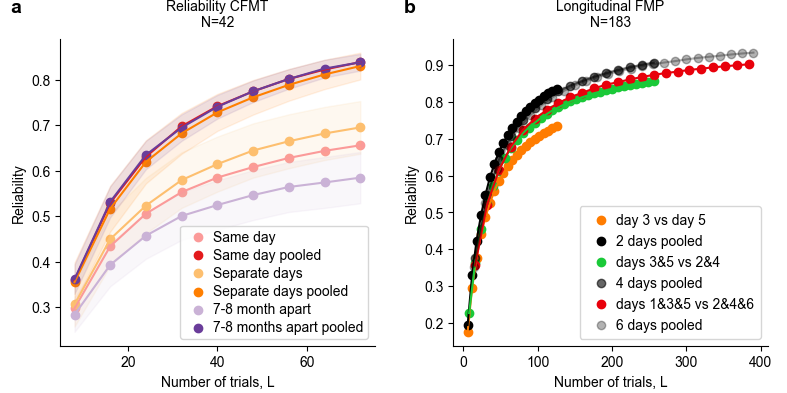

In [62]:
#######################
# define canvas

from cand import Canvas, Vector, Point
import matplotlib.ticker as ticker

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=10


# CanD
a = 20
b = 10
# rot = 15
c = Canvas(a, b, "cm")

# set font
# c.set_font("Helvetica", size=10)
c.set_font("Arial", size=10)

# letters
# c.add_text("A", Point(.05, 0.98), weight="bold")
c.add_text("a", Point(.02, 0.98), weight="bold", size=font_size)
c.add_text("b", Point(.52, 0.98), weight="bold", size=font_size)
# c.add_text("c", Point(.02, 0.32), weight="bold", size=font_size)
           
# titles
titles = [f'Reliability longitudinal FMP, N={N_FMP_long_nooutliers_all_days}, removed outliers >2SD', f"""Reliability CFMT, Female and Australian version, first visits only, removed outliers with diff score>{std_thr}SD
N_sep={N_CFMT_AusF_nooutliers}, N_same={N_CFMT_Aus2F2_nooutliers}, N_7m={N_CFMT_origFmonth_nooutliers}, n$_{{\mathrm{{concat}}}}$={total_n_trials_CFMT_Aus2F2_concat_nooutliers}, n$_{{\mathrm{{Aus}}}}$={total_n_trials_CFMT_Aus2_nooutliers}, n$_{{\mathrm{{F}}}}$={total_n_trials_CFMT_F2_nooutliers}, n_iter={N_iter_sampling}"""]
# c.add_text(titles[0], Point(.27, 0.947), size=font_size)
for title in titles:
    print(title)

# ### GRID
# # top row, panel A
top_offset = 1.#5
bottom_offset = 1.2#5
right_offset = 1.53
hsb = 2.4 #half_space_between - horizontal
vsb = 2 #half_space_between - vertical

# add a 3x2 grid, "High Reliability, High/Middle/Low Correlation"
c.add_grid(["CFMT", "FMP"], 1, Point(right_offset, bottom_offset, "cm"), Point(a-0.5, b-top_offset, "cm"), spacing=Vector(vsb, hsb, "cm"), unitname="grid")


# define colours
palette = sns.color_palette("bright", n_colors=4, as_cmap=False)
colour_day3and5 = palette[1]
colour_day35and24 = palette[2]
colour_day135and246 = palette[3]
pallette_CFMT = sns.color_palette("Paired", n_colors=20, as_cmap=False)[4:]
# pallette_CFMT_same = [pallette_CFMT[4], pallette_CFMT[5]]
pallette_CFMT_separate = pallette_CFMT[2:]


palette_tasks = sns.color_palette("bright", n_colors=len(task4analysis), as_cmap=False)
colour_day1 = palette_tasks[6]
colour_day2 = palette_tasks[2]
colour_day1vsday = palette_tasks[0]

# define if to plot the error in CFMT
plot_error = True



############################ PLOT CFMT
# plot same day, Aus2 vs F2
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_Aus2F2_nooutliers, n_trials_list_CFMT_Aus2F2_nooutliers, 'Same day'),
    (array_corr_fxn_CFMT_Aus2F2_concat_nooutliers, n_trials_list_CFMT_Aus2F2_concat_nooutliers, 'Same day pooled'),
]):
    c.ax('CFMT').scatter(x_list, np.nanmean(arr, axis=1), label=f'{label}', color=pallette_CFMT[i])
    c.ax('CFMT').plot(x_list, np.nanmean(arr, axis=1), color=pallette_CFMT[i])

# plot the sampled data
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_CFMT_AusF_nooutliers_sampled, n_trials_list_CFMT_AusF_nooutliers_sampled, 'Separate days'),
    (array_corr_fxn_CFMT_concat_AusF_nooutliers_sampled, n_trials_list_CFMT_concat_AusF_nooutliers_sampled, 'Separate days pooled'),
    (array_corr_fxn_CFMT_origFmonth_nooutliers_sampled, n_trials_list_CFMT_origFmonth_nooutliers_sampled, '7-8 month apart'),
    (array_corr_fxn_CFMT_concat_origFmonth_nooutliers_sampled, n_trials_list_CFMT_concat_origFmonth_nooutliers_sampled, '7-8 months apart pooled'),
]):
    # make first the nan
    arr = np.nanmean(arr, axis=-1)
#     c.ax('CFMT').errorbar(x_list, np.nanmean(arr, axis=0), yerr=np.nanstd(arr, axis=0), fmt='o', capsize=2, c=pallette_CFMT[i+2], label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}')
    c.ax('CFMT').plot(x_list, np.nanmean(arr, axis=0), color=pallette_CFMT_separate[i])
    c.ax('CFMT').scatter(x_list, np.nanmean(arr, axis=0), c=pallette_CFMT_separate[i], label=f'{label}')
    
    if plot_error:
        c.ax('CFMT').fill_between(
            x_list,
            np.nanmean(arr, axis=0)-np.nanstd(arr, axis=0),
            np.nanmean(arr, axis=0)+np.nanstd(arr, axis=0),
    #         label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}',
            color=pallette_CFMT_separate[i], alpha=0.1,
        )
    
c.ax('CFMT').legend(loc="lower right", columnspacing=0.01, labelspacing=0.3, borderpad=0.3, handletextpad=0.1)

c.ax('CFMT').set_ylabel('Reliability')
c.ax('CFMT').set_xlabel('Number of trials, L')

c.add_text(f"Reliability CFMT\nN={min(N_CFMT_AusF_nooutliers, N_CFMT_Aus2F2_nooutliers, N_CFMT_origFmonth_nooutliers)}", 
           Point(.5, 1.08, "axis_CFMT"))


############################ PLOT FMP
c.ax('FMP').scatter(n_trials_list_day3vs5_nooutliers, np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1), label=f'day 3 vs day 5', color=colour_day3and5)
c.ax('FMP').plot(n_trials_list_day3vs5_nooutliers, np.nanmean(array_corr_fxn_day3vs5_nooutliers, axis=1), color=colour_day3and5)

# add the full concatenated 2 forms
c.ax('FMP').scatter(n_trials_list_day3and5_concat_nooutliers, np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1), label=f'2 days pooled', color='k')
c.ax('FMP').plot(n_trials_list_day3and5_concat_nooutliers, np.nanmean(array_corr_fxn_day3and5_concat_nooutliers, axis=1), color='k')


#######
c.ax('FMP').scatter(n_trials_list_day35vs24_nooutliers, np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1), label=f'days 3&5 vs 2&4', color=colour_day35and24)
c.ax('FMP').plot(n_trials_list_day35vs24_nooutliers, np.nanmean(array_corr_fxn_day35vs24_nooutliers, axis=1), color=colour_day35and24)

# add the full concatenated 4 forms
c.ax('FMP').scatter(n_trials_list_day2345_concat_nooutliers, np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1), label=f'4 days pooled', color='k', alpha=0.6)
c.ax('FMP').plot(n_trials_list_day2345_concat_nooutliers, np.nanmean(array_corr_fxn_day2345_concat_nooutliers, axis=1), color='k', alpha=0.6)


#######
c.ax('FMP').scatter(n_trials_list_day135vs246_nooutliers, np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1), label=f'days 1&3&5 vs 2&4&6', color=colour_day135and246)
c.ax('FMP').plot(n_trials_list_day135vs246_nooutliers, np.nanmean(array_corr_fxn_day135vs246_nooutliers, axis=1), color=colour_day135and246)

# add the full concatenated 6 forms
c.ax('FMP').scatter(n_trials_list_alldays_concat_nooutliers, np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1), label=f'6 days pooled', color='k', alpha=0.3)
c.ax('FMP').plot(n_trials_list_alldays_concat_nooutliers, np.nanmean(array_corr_fxn_alldays_concat_nooutliers, axis=1), color='k', alpha=0.3)


## polish
c.ax('FMP').legend(loc="lower right", columnspacing=0.01, labelspacing=.5, borderpad=0.5, handletextpad=0.1)

c.ax('FMP').set_ylabel('Reliability')
c.ax('FMP').set_xlabel('Number of trials, L')

c.add_text(f"Longitudinal FMP\nN={N_FMP_long_nooutliers_all_days}", Point(.5, 1.08, "axis_FMP"))


### make it nice
for ax in c.axes.values():
    sns.despine(ax=ax)

    
## --------------------------------------------------    
    
# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
#
# c.save(os.path.join(path_figures, "Fig4", 'Figure_4.png'), dpi=300)#, bbox_inches="tight")
# c.save(os.path.join(path_figures, "Fig4", 'Figure_4.pdf'), dpi=300)#, bbox_inches="tight")

#### CanD scatterplots
[top](#top)

CCMT
Starting with N=154 subjects.
diff:2SD, perf:None
Dropping 6 outliers for score difference
Total number of trials is 72.
Total number of trials is 72.
Total number of trials is 144.
FMP
Starting with N=119 subjects.
diff:2SD, perf:None
Dropping 3 outliers for score difference
Total number of trials is 180.
Total number of trials is 180.
Total number of trials is 360.
GFMT
Starting with N=157 subjects.
diff:2SD, perf:None
Dropping 6 outliers for score difference
Total number of trials is 40.
Total number of trials is 40.
Total number of trials is 80.
MST
Starting with N=84 subjects.
diff:2SD, perf:None
Dropping 4 outliers for score difference
Total number of trials is 320.
Total number of trials is 320.
Total number of trials is 640.
PGNG
Starting with N=152 subjects.
diff:2SD, perf:None
Dropping 12 outliers for score difference
Total number of trials is 116.
Total number of trials is 116.
Total number of trials is 232.
PIM_MC
Starting with N=152 subjects.
diff:2SD, perf:None
Dropp

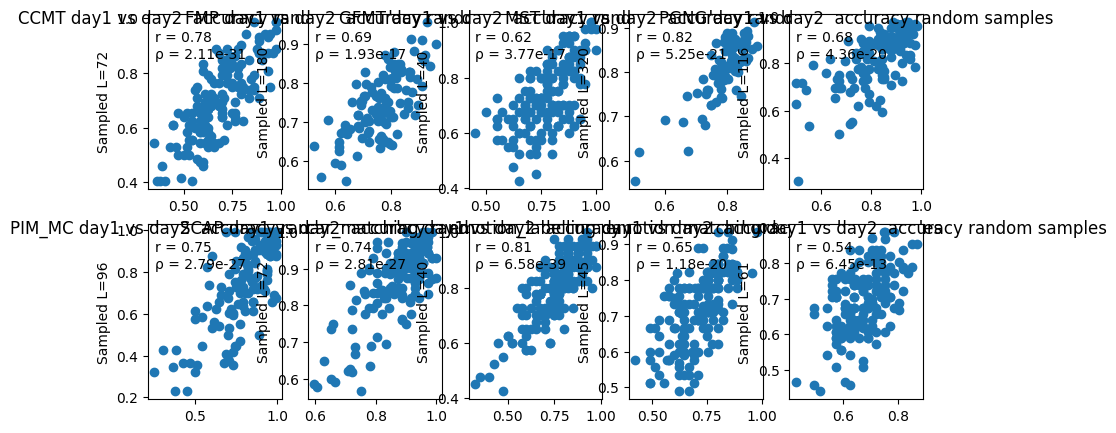

In [63]:
dic_scatterplots = {}

# how many samples we want to correlate
n_repeats = 1

# start the timer
start = time.time()

fig, axs = plt.subplots(2, 5, figsize=(10,5))

# run without nback as it is not behaving well
# for task in task4analysis:
for task, ax in zip(task4analysis, axs.flatten()):
    
    # start the timer
    start_task = time.time()
    
    # be sure and clean
    df_temp = None
    df_temp_cleaned = None
    print(task)
    # extract data
    if task == "nback_lvl2":
        df_temp = [x for x in dataframe_list if x.task.str.contains('nback').all()][0]
        df_temp = df_temp.loc[df_temp["level"]==2]
    else:
        df_temp = [x for x in dataframe_list if x.task.str.contains(task).all()][0]

    if task == "PIM_MC":
        # merge and flat all the cols
        df_temp = pd.melt(df_temp[['userID', 'hobby', 'vice', 'code_name', 'country', 'form']], 
                          id_vars=['userID', 'form'], value_name='correct')
    
    # check that the forms are there
    assert set(["original", "repetition"]) == set(df_temp["form"].unique())
    print(f"Starting with N={df_temp['userID'].unique().size} subjects.")
    
    # go over all conditions of cleaning
    for diff_c, perf_c in cleaning_conditions:
        # copy the df to be able to clean it
        df_temp_cleaned = df_temp.copy()
        
        # define condition
        condition = f'diff:{diff_c}, perf:{perf_c}'
        print(condition)
        
        # define outliers that we want to drop on accuracy
        if perf_c is not None:
            # check if it's SD or %
            if 'SD' in perf_c:
                # find the SD and select the SD
                std_thr_acc = float(perf_c.strip('SD'))
                # add label
                condition += '_bottom'
                           
                for form in ["original", "repetition"]:        
                    # compute the mean, use the original dataset and not the one that will already be partially cleaned
                    tmp_series = df_temp.loc[df_temp["form"]==form].groupby(['userID']).correct.mean()
                    mu_acc = tmp_series.mean() #df_temp['correct'].mean()
                    std_acc = tmp_series.std() #df_temp.groupby(['userID']).correct.mean().std()
                    outliers_acc = set(tmp_series[tmp_series<mu_acc-std_acc*std_thr_acc].dropna().index)
                    # drop the outliers form the cleaned dataset
                    df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers_acc)]
                    print(f'Dropping {len(outliers_acc)} outliers for accuracy in {form}')
            
            elif '%' in perf_c:
                # drop the perf_c percent of the scores
                std_thr_acc = float(perf_c.strip('%'))/100
                for form in ["original", "repetition"]:        
                    # take the n smallest scores where n is proportional to the threshold
                    outliers_acc = tmp_series.nsmallest(int(np.round(len(tmp_series)*std_thr_acc))).index
                    # drop the outliers form the cleaned dataset
                    df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers_acc)]
                    print(f'Dropping {len(outliers_acc)} outliers for accuracy in {form}')
                    
            else:
                raise ValueError(f'Provided value cannot be processed: {perf_c}')
        
        # there is no else because if it is None, then we are not cleaning which means that we continue with the original dataset
                
        
        # define outliers that we want to drop on score difference between visits
        if diff_c is not None:            
            # compute the score difference
            tmp_score_diff = df_temp_cleaned.loc[df_temp_cleaned["form"]=="original", ["userID", "correct"]].groupby('userID').mean() - df_temp_cleaned.loc[df_temp_cleaned["form"]=="repetition", ["userID", "correct"]].groupby('userID').mean()

            # check if it's SD or %
            if 'SD' in diff_c:
                std_thr = float(diff_c.strip('SD'))
                # drop participants whose difference in score on first and second step is large
                mu = tmp_score_diff.mean()[0]
                std = tmp_score_diff.std()[0]
                outliers = set(tmp_score_diff[tmp_score_diff<mu-std*std_thr].dropna().index)|set(tmp_score_diff[tmp_score_diff>mu+std*std_thr].dropna().index)
                df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers)]
                
            elif '%' in diff_c:
                # drop the perf_c percent of the scores
                std_thr = float(diff_c.strip('%'))/100
                
                # take the n larges differences in scores where n is proportional to the threshold
                outliers = tmp_score_diff.abs().nlargest(int(np.round(len(tmp_score_diff)*std_thr)), 'correct').index
                # drop the outliers form the cleaned dataset
                df_temp_cleaned = df_temp_cleaned[~df_temp_cleaned['userID'].isin(outliers)]
                
                
            print(f'Dropping {len(outliers)} outliers for score difference')
        

        # extract to arrays
        N_temp = df_temp_cleaned['userID'].unique().size

        ## original
        # max number of trials
        total_n_trials_orig = check_df_get_numbers(df_temp_cleaned.loc[df_temp_cleaned["form"]=="original", ['userID', 'correct']], N_temp)
        # extract the data
        all_trials_reshaped_orig = extract_data(df_temp_cleaned.loc[df_temp_cleaned["form"]=="original", ['userID', 'correct']], total_n_trials_orig, measure="correct")

        ## repetition
        # max number of trials
        total_n_trials_rep = check_df_get_numbers(df_temp_cleaned.loc[df_temp_cleaned["form"]=="repetition", ['userID', 'correct']], N_temp)
        # extract the data
        all_trials_reshaped_rep = extract_data(df_temp_cleaned.loc[df_temp_cleaned["form"]=="repetition", ['userID', 'correct']], total_n_trials_rep, measure="correct")


        ## concat
        # max number of trials
        total_n_trials_concat = check_df_get_numbers(df_temp_cleaned.loc[:, ['userID', 'correct']], N_temp)
        # extract the data
        all_trials_reshaped_concat = extract_data(df_temp_cleaned.loc[:, ['userID', 'correct']], total_n_trials_concat, measure="correct")

        # define step, take only one
        step = total_n_trials_concat//2

        x, y, n_trials_list = calculate_reliability_between_two_groups_scatterplots(all_trials_reshaped_orig, all_trials_reshaped_rep, total_n_trials_orig+total_n_trials_rep, n_repeats=n_repeats, test=task+' day1 vs day2 ', step=step, axs=ax)
#         calculate_reliability_between_two_groups_scatterplots(all_trials_reshaped_concat, all_trials_reshaped_concat, total_n_trials_concat, n_repeats=n_repeats, test=task+' concat ', step=step, axs=ax)
        
        dic_scatterplots[task] = {'x':x, 'y':y, 'L': n_trials_list}


{'name': 'Arial'}
Reliability scatterplots: reliability stability across visits per task


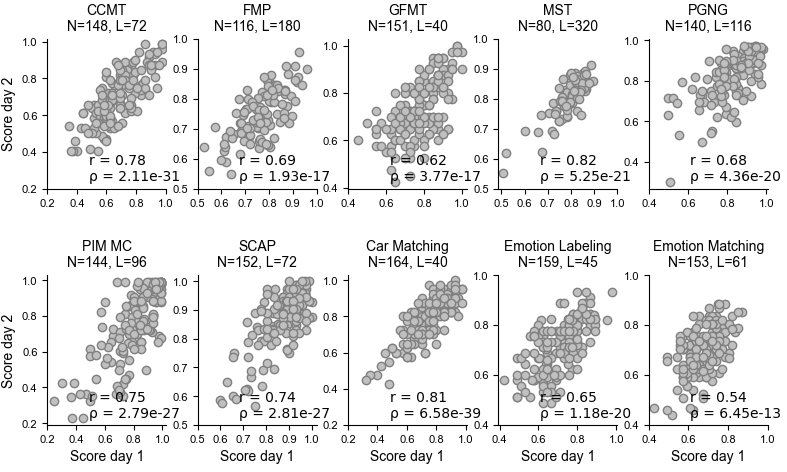

In [64]:
#######################
# define canvas

from cand import Canvas, Vector, Point
import matplotlib.ticker as ticker
from plot_functions import sharey_ax

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=8


# CanD
a = 20
b = 12
c = Canvas(a, b, "cm")

# set font
# c.set_font("Helvetica", size=10)
c.set_font("Arial", size=10, ticksize=legend_size)

# letters
# c.add_text("A", Point(.05, 0.98), weight="bold")
# c.add_text("A)", Point(.02, 0.98), weight="bold", size=font_size)
# c.add_text("B)", Point(.02, 0.5), weight="bold", size=font_size)
           
# titles
titles = ["Reliability scatterplots: reliability stability across visits per task"]
# c.add_text(titles[0], Point(.5, 0.98), size=font_size)
# c.add_text(titles[1], Point(.82, 0.967), size=font_size)
# c.add_text(titles[2], Point(.47, 0.5), size=font_size)
for title in titles:
    print(title)

# ### GRID
# # top row, panel A
top_offset = 1.
bottom_offset = 1.2
right_offset = 1.2
hsb = 2.2 #half_space_between - horizontal
vsb = .8 #half_space_between - vertical

# add a 5x2 grid
c.add_grid([f"p{i}" for i in range(len(task4analysis))], 2, Point(right_offset, bottom_offset, "cm"), Point(a-.5, b-top_offset, "cm"), spacing=Vector(vsb, hsb, "cm"), unitname="grid")



######### panel A
for (i, ax), task in zip(enumerate(c.axes.values()), task4analysis):

    x = dic_scatterplots[task]['x']
    y = dic_scatterplots[task]['y']
    ax.scatter(x, y, edgecolors='gray', color='silver')
    label_correlation(x, y, ax, xy=(.35, .05))# xy=(.02, .83))#


    ax_title = task.replace("_", " ").replace("pseudoslopes", "").replace("concat", "").replace("labelling", "labeling").replace("faces-perc", "\ninterference - FM").replace("faces", "interference").replace("blank", "delay").replace("perception", "face matching").replace(" birds planes leaves", "").replace("n back", "N Back").replace("nback  level2 d prime", "N Back d'")
    if 'emotion' in ax_title or 'car' in ax_title:
        ax_title = ax_title.title() 
#     ax.set_title(ax_title)
    ax.set_title(f'{ax_title}\nN={x.shape[0]}, L={dic_scatterplots[task]["L"][0]}')
#     c.add_text(f'{ax_title}\nN={x.shape[0]}', Point(.5, 1., f"p{i}"))

    
    # deal with labels
    if i>= len(task4analysis)-5:
        ax.set_xlabel("Score day 1")
    else:
        ax.set_xlabel("")
    
    if i%5==0:
        ax.set_ylabel("Score day 2")
        source_ax = ax
    else:
        ax.set_ylabel("")
#         sharey_ax(ax, source_ax)

    
    sns.despine(ax=ax)
    
#     ax.set_xlim(min(x.min(), y.min())-0.05, 1.05)
#     ax.set_ylim(min(x.min(), y.min())-0.05, 1.05)
    
    # set the x axis to look good
#     ax.xaxis.set_ticks([a.get_position()[1] for a in ax.yaxis.get_ticklabels()])#ax.get_yticks())
#     ax.yaxis.set_ticks([a.get_position()[0] for a in ax.xaxis.get_ticklabels()])#ax.get_yticks())
#     print(f'{ax_title}:\n y: {ax.yaxis.get_ticklabels()}\n x: {ax.xaxis.get_ticklabels()}\n')

#     ax.xaxis.set_ticks(np.arange(0, 1.2, 0.2))
#     ax.xaxis.set_ticks(np.arange(0.2, 1.2, 0.2))
#     ax.yaxis.set_ticks(np.arange(0.2, 1.2, 0.2))
    if x.min()>0.5:
        ax.xaxis.set_ticks(np.arange(0.5, 1.05, 0.1))
    elif x.min()>0.4:
        ax.xaxis.set_ticks(np.arange(0.4, 1.2, 0.2))
    else:
        ax.xaxis.set_ticks(np.arange(0.2, 1.2, 0.2))
#     ax.yaxis.set_ticks(np.arange(0.2, 1.2, 0.2))
#     print(x.min(), y.min())
    ax.yaxis.set_ticks(ax.get_xticks())

    
# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
# #
# c.save(os.path.join(path_figures, "SI", 'Figure_x.png'), dpi=300)#, bbox_inches="tight")
# c.save(os.path.join(path_figures, "SI", 'Figure_x.pdf'), dpi=300)#, bbox_inches="tight")

{'name': 'Arial'}
Reliability scatterplots: reliability stability across visits per task


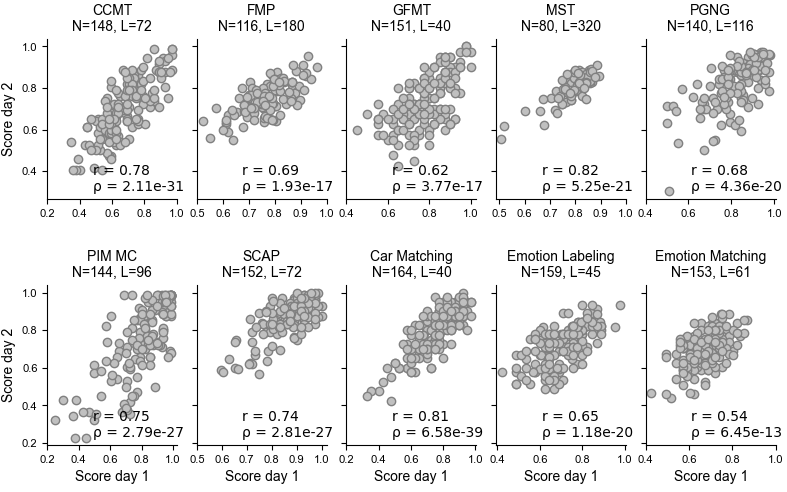

In [65]:
#######################
# define canvas

from cand import Canvas, Vector, Point
import matplotlib.ticker as ticker
from plot_functions import sharey_ax

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=8


# CanD
a = 20
b = 12.5
c = Canvas(a, b, "cm")

# set font
# c.set_font("Helvetica", size=10)
c.set_font("Arial", size=10, ticksize=legend_size)

# letters
# c.add_text("A", Point(.05, 0.98), weight="bold")
# c.add_text("A)", Point(.02, 0.98), weight="bold", size=font_size)
# c.add_text("B)", Point(.02, 0.5), weight="bold", size=font_size)
           
# titles
titles = ["Reliability scatterplots: reliability stability across visits per task"]
# c.add_text(titles[0], Point(.5, 0.98), size=font_size)
# c.add_text(titles[1], Point(.82, 0.967), size=font_size)
# c.add_text(titles[2], Point(.47, 0.5), size=font_size)
for title in titles:
    print(title)

# ### GRID
# # top row, panel A
top_offset = 1.
bottom_offset = 1.2
right_offset = 1.2
hsb = 2.2 #half_space_between - horizontal
vsb = .5 #half_space_between - vertical

# add a 5x2 grid
c.add_grid([f"p{i}" for i in range(len(task4analysis))], 2, Point(right_offset, bottom_offset, "cm"), Point(a-.3, b-top_offset, "cm"), spacing=Vector(vsb, hsb, "cm"), unitname="grid")



######### panel A
for (i, ax), task in zip(enumerate(c.axes.values()), task4analysis):

    x = dic_scatterplots[task]['x']
    y = dic_scatterplots[task]['y']
    ax.scatter(x, y, edgecolors='gray', color='silver')
    label_correlation(x, y, ax, xy=(.35, .05))


    ax_title = task.replace("_", " ").replace("pseudoslopes", "").replace("concat", "").replace("labelling", "labeling").replace("faces-perc", "\ninterference - FM").replace("faces", "interference").replace("blank", "delay").replace("perception", "face matching").replace(" birds planes leaves", "").replace("n back", "N Back").replace("nback  level2 d prime", "N Back d'")
    if 'emotion' in ax_title or 'car' in ax_title:
        ax_title = ax_title.title() 
#     ax.set_title(ax_title)
    ax.set_title(f'{ax_title}\nN={x.shape[0]}, L={dic_scatterplots[task]["L"][0]}')
#     c.add_text(f'{ax_title}\nN={x.shape[0]}', Point(.5, 1., f"p{i}"))

    
    # deal with labels
    if i>= len(task4analysis)-5:
        ax.set_xlabel("Score day 1")
    else:
        ax.set_xlabel("")
    
    if i%5==0:
        ax.set_ylabel("Score day 2")
        source_ax = ax
    else:
        #ax.set_ylabel("")
        sharey_ax(ax, source_ax)

    
    sns.despine(ax=ax)
    
    
    if x.min()>0.5:
        ax.xaxis.set_ticks(np.arange(0.5, 1.05, 0.1))
    elif x.min()>0.4:
        ax.xaxis.set_ticks(np.arange(0.4, 1.2, 0.2))
    else:
        ax.xaxis.set_ticks(np.arange(0.2, 1.2, 0.2))
    
#     ax.yaxis.set_ticks(ax.get_xticks())
    
# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
# #
# c.save(os.path.join(path_figures, "SI", 'Figure_x.png'), dpi=300)#, bbox_inches="tight")
# c.save(os.path.join(path_figures, "SI", 'Figure_x.pdf'), dpi=300)#, bbox_inches="tight")

In [66]:
%load_ext watermark

%watermark -a 'Jan Kadlec' -nmvu -iv

Author: Jan Kadlec

Last updated: Sun Dec 17 2023

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 23.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

matplotlib: 3.6.2
seaborn   : 0.11.1
sys       : 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
numpy     : 1.19.1
pandas    : 1.2.4



[top](#top)